In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import joblib,math,re,warnings
# 特征缩放模块
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
# scikit-learn 的特征选择模块
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# 机器学习模块
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings("ignore")
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

# 从 list1 中删除 list2 中包含的元素，返回一个新list
def remove_from_one_list(list1,list2):
    z = []
    for m in list1:
        if m not in list2:
            z.append(m)
    return z


def rf(X_train, y_train):
    # 随机森林树回归
    
    RForest = RandomForestRegressor(max_leaf_nodes=1000,n_estimators=10000,max_features="sqrt",n_jobs=-1,random_state=0,oob_score=False)
#     param_grid=dict(max_depth = [10,100])
#     grid_search = GridSearchCV(RForest,param_grid,n_jobs = -1,cv = 5)
#     grid_result = grid_search.fit(X_train, y_train) #运行网格搜索
    
#     RForest=grid_result.best_estimator_
    RForest.fit(X_train,y_train)
    return RForest

def print_model_regression_results(model,train_dataset,test_dataset):
    y = test_dataset['y']
    X = test_dataset[remove_from_one_list(list(test_dataset.columns),['y'])]
    X_train=train_dataset[remove_from_one_list(list(test_dataset.columns),['y'])]
    r2 = r2_score(train_dataset['y'].ravel(),model.predict(X_train))
    q2 = r2_score(y,model.predict(X))
    rmse = sqrt(mean_squared_error(y, model.predict(X)))
    mae = mean_absolute_error(y, model.predict(X))
    print("R2   ", r2)
    print("Q2  ", q2)
    print('RMSE  ', rmse)
    print('MAE  ', mae)

In [6]:
data = pd.read_csv("k_without_amide_and_aniline.csv",index_col = 'ids')

# # data = data.loc[(data["fr_amide"]==0)]
# data=data.drop('CC(C)NCC(CO)c1ccccc1') #axis参数默认为0
# selected_column = ['y','VSA_EState4', 'ssNH_eState', 'VSA_EState3', 'MaxEStateIndex', 'SMR_VSA3', 'sNH2_eState', 'SMR_VSA4', 'TPSA', 'EState_VSA9', 'SlogP_VSA1', 'SlogP_VSA2', 'PEOE_VSA1', 'EState_VSA8', 'SMR_VSA6']


feature_column = remove_from_one_list(data.columns,['y'])

# data = data[selected_column]
train_dataset = data[:240]
test_dataset = data[60:]



In [7]:
# df = pd.DataFrame(train_dataset).copy()

# abnormal_items_set = set()
# abnormal_items = {}
# # 对每个特征进行计算
# for col_name in df:
#     abnormal_items[col_name]=[]
#     feature_values = df[col_name]
#     mean_ = feature_values.mean()
#     std_ = feature_values.std()
#     for index,i in enumerate(feature_values):
#         score = abs(i - mean_) / std_
#         if float(score) > 3.0 :
#             abnormal_items[col_name].append(df.iloc[index].name)
#             abnormal_items_set.add(df.iloc[index].name)

# len(abnormal_items_set)

In [8]:
# for key,values in abnormal_items.items():
#     for value in values:
#         if value != "MDEA":
#             df.loc[value,key] = np.nan

# train_dataset=df.dropna()



In [9]:
np.mean(train_dataset["y"])

-9.66600624572917

In [10]:
y_train = train_dataset['y']
X_train = train_dataset[feature_column]
X_test = test_dataset[feature_column]
y_test = test_dataset['y']

In [11]:
model_xgb = rf(X_train,y_train)

print_model_regression_results(model_xgb,train_dataset,test_dataset)



R2    0.9584801650721045
Q2   0.9204170958744304
RMSE   1.3031443845822697
MAE   0.8428614751559493


In [12]:
print(y_test-model_xgb.predict(X_test))


ids
CC(C)CNC(=O)CCO   -2.088906
CC(C)CNC(CO)CO    -1.272037
CC(C)CNCCN        -0.152578
CC(C)CNCCO        -0.045969
CC(C)NC(=O)CCO    -1.305153
                     ...   
NCCOC1CCCC1        0.376605
NCCOCc1ccco1      -1.966854
NCCOCCN            0.618310
NCCOCNCc1ccccc1    0.525875
OCC1CCNCC1        -0.125292
Name: y, Length: 240, dtype: float64


['MaxEStateIndex', 'VSA_EState3', 'VSA_EState4', 'MinEStateIndex', 'BCUT2D_MRHI', 'TPSA', 'BCUT2D_MRLOW']

['PEOE_VSA5', 'SMR_VSA9', 'SlogP_VSA1', 'NHOHCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'fr_Al_OH', 'fr_NH1', 'fr_amide']

['SlogP_VSA9', 'NumValenceElectrons', 'BCUT2D_MRHI', 'NumRadicalElectrons', 'Chi2n', 'MaxEStateIndex', 'PEOE_VSA9']

In [13]:
import shap

In [14]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)


In [15]:
shap.initjs()

In [16]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])


In [17]:
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])


In [18]:
import matplotlib as mpl

mpl.rcParams['font.sans-serif']=['Arial'] # 字体Arial

mpl.rcParams['font.size'] = 40
# mpl
mpl.rcParams['axes.grid'] = False  # 不显示网格
mpl.rcParams['lines.linewidth'] = 3 # 线宽
mpl.rcParams['axes.linewidth'] = 3 # 边框线宽
# mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"

In [19]:
feature_column

['HeavyAtomCount',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',
 'MolLogP',
 'MolMR',
 'fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_Nhpyrrole',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amide',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_barbitur',
 'fr_benzene',
 'fr_benzodiazepine',
 'fr_bicyclic',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_ester',


In [20]:
import matplotlib.pyplot as plt
plt.figure()

mpl.rcParams['text.color']='blue'


In [21]:
# shap_values_bar = explainer(X_train)
# shap.plots.bar(shap_values_bar,max_display=20)
# shap.plots.bar(shap_values.abs.mean(0))



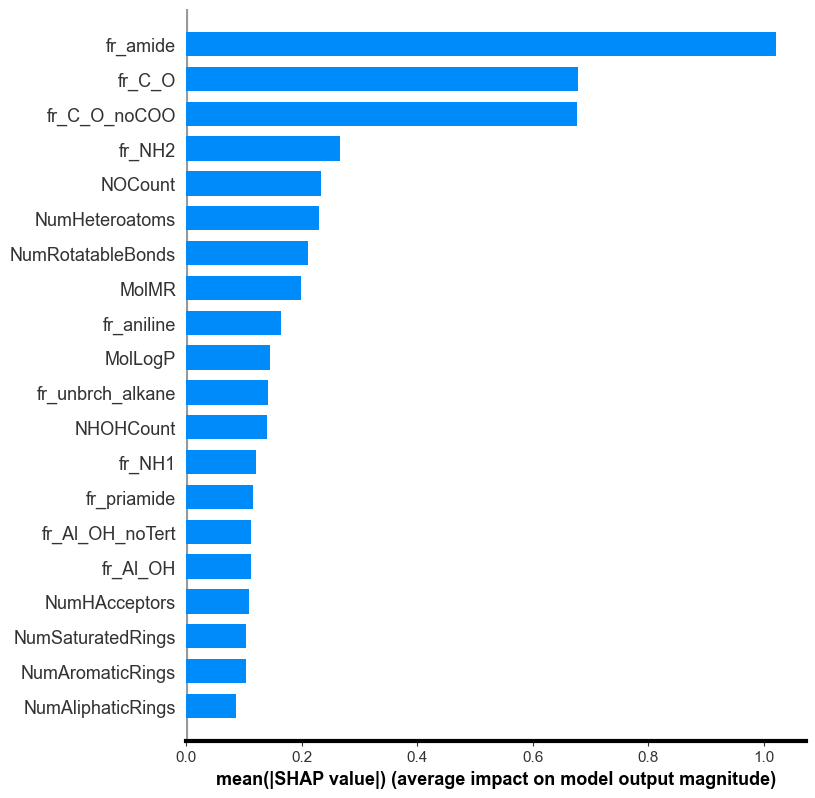

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar")



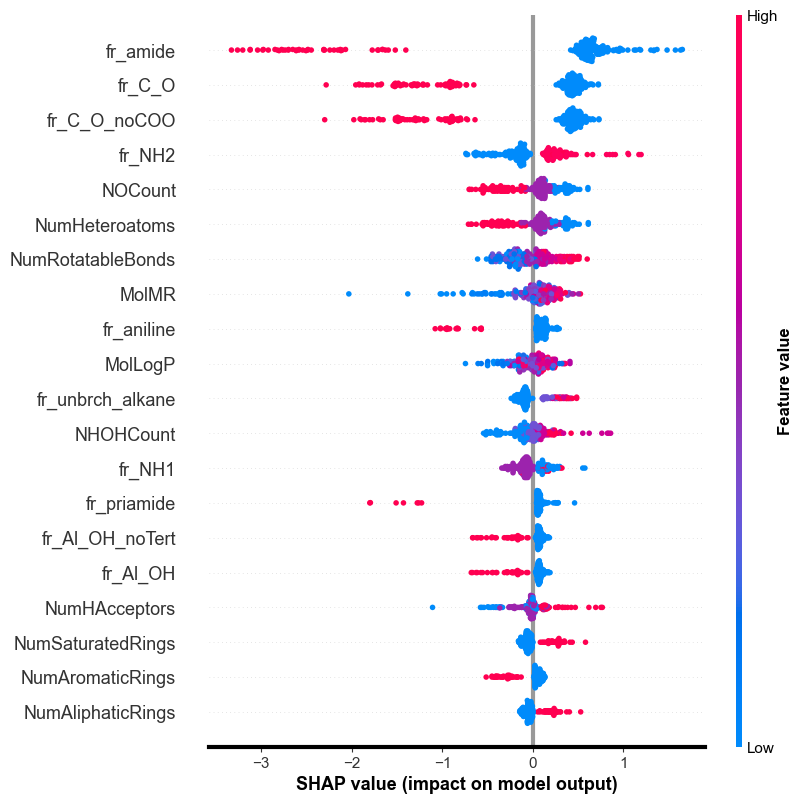

In [23]:
shap.summary_plot(shap_values, X_train)




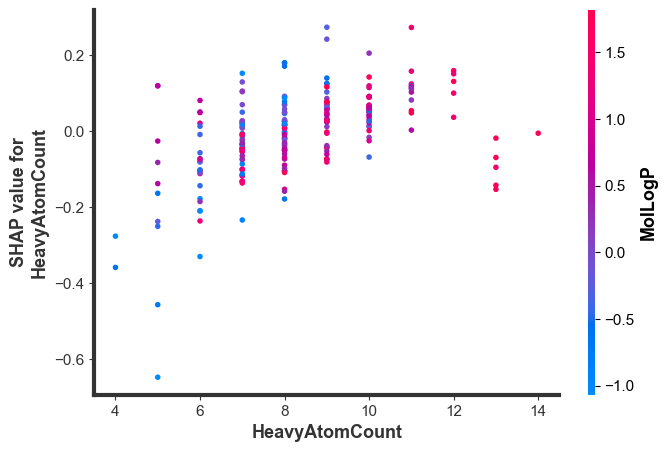

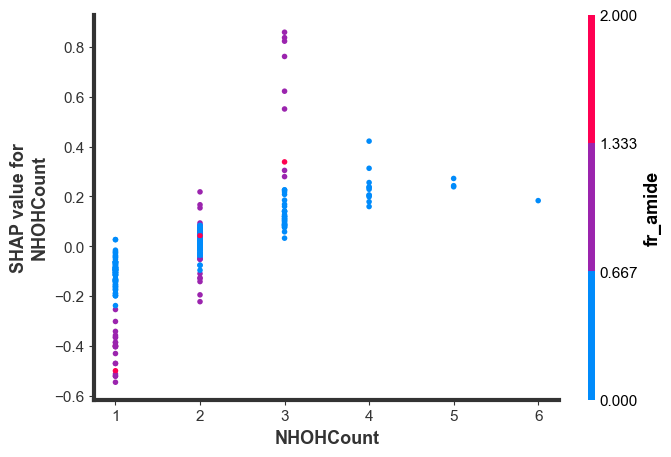

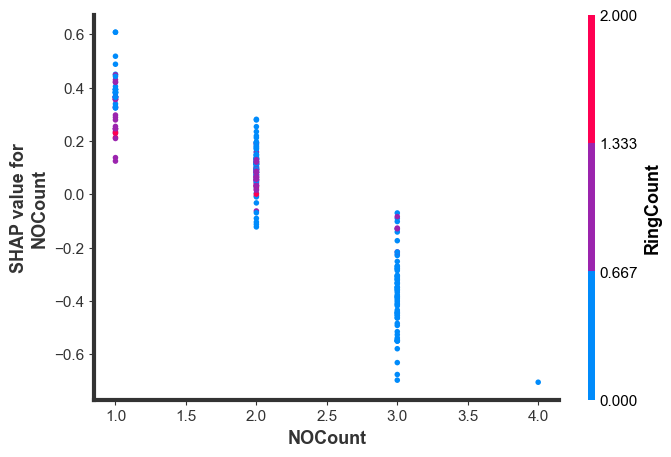

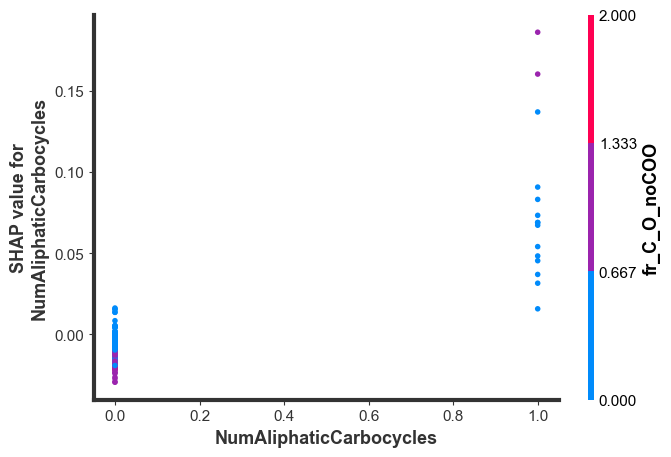

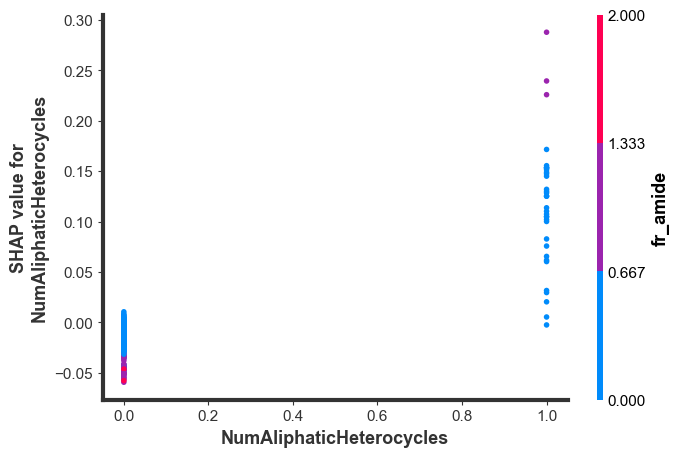

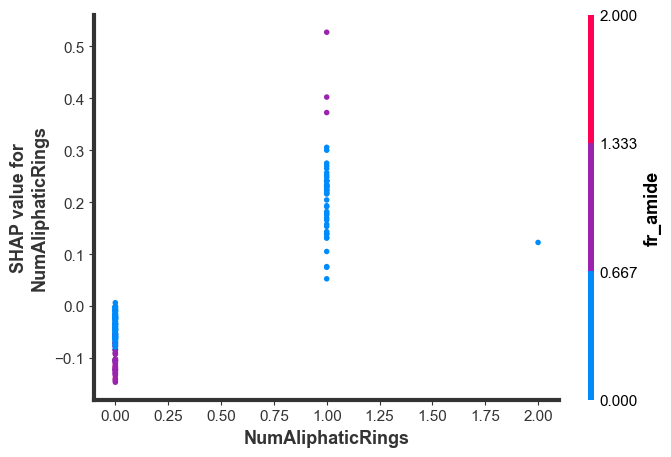

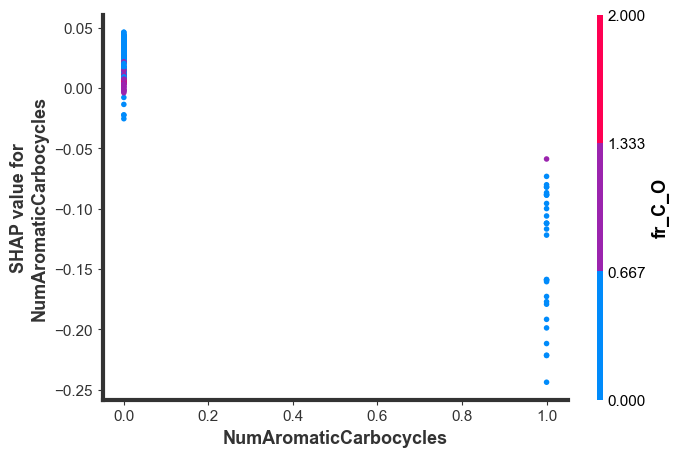

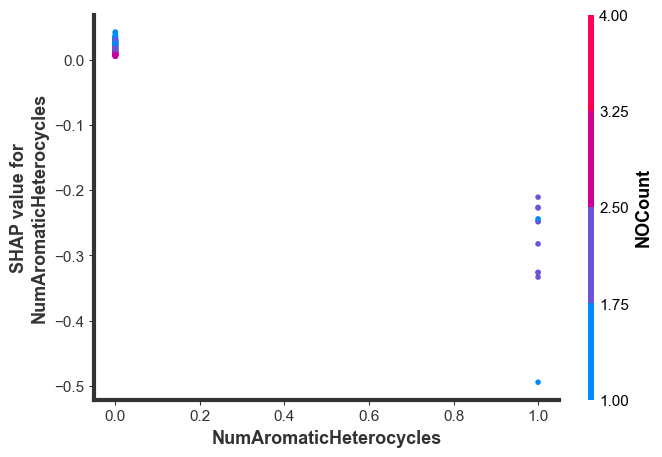

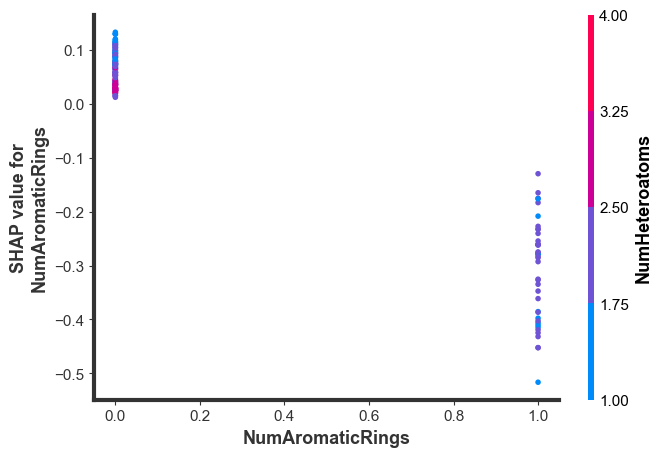

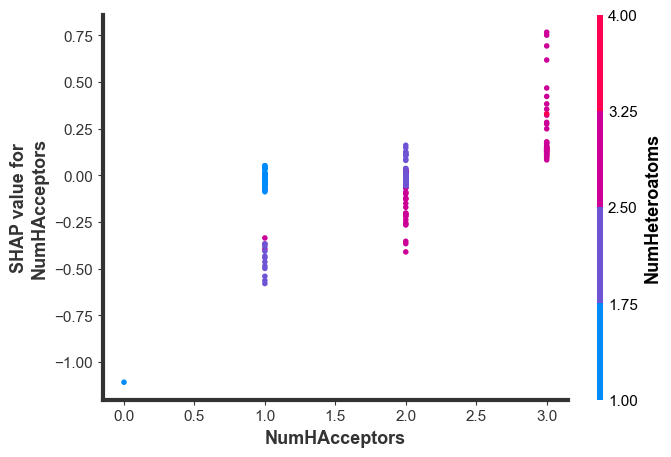

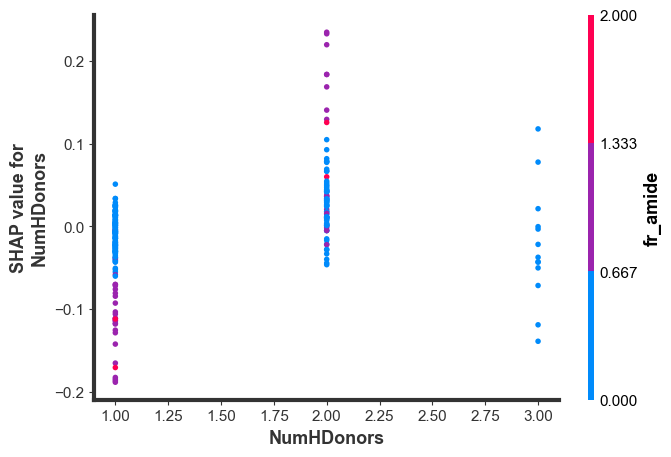

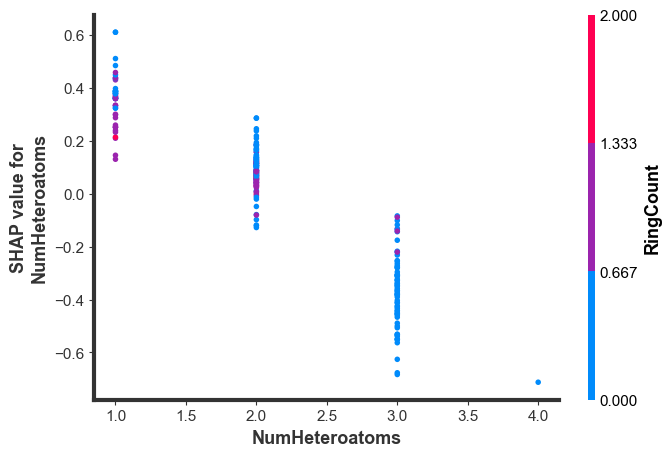

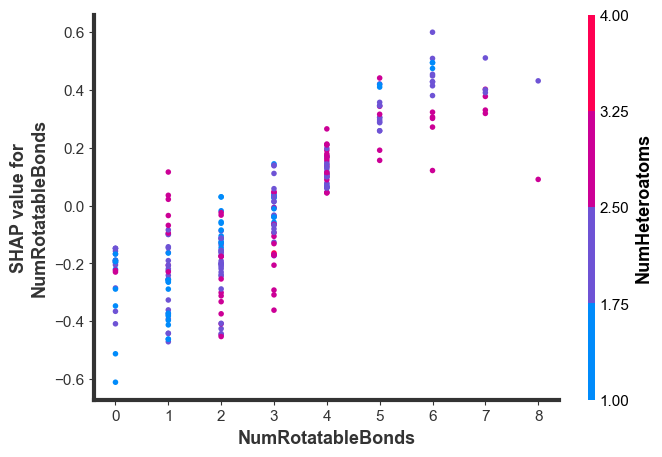

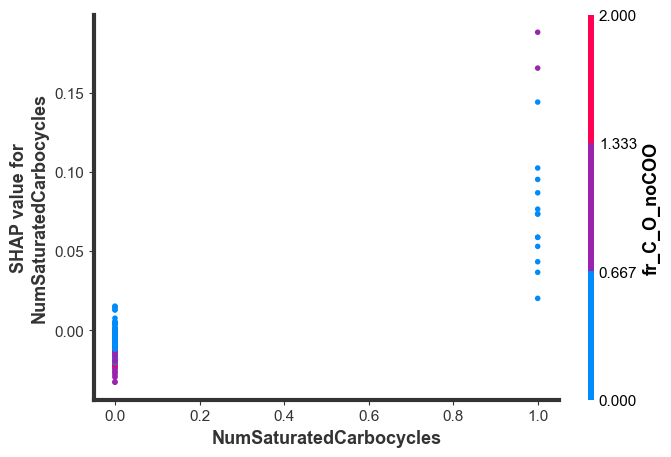

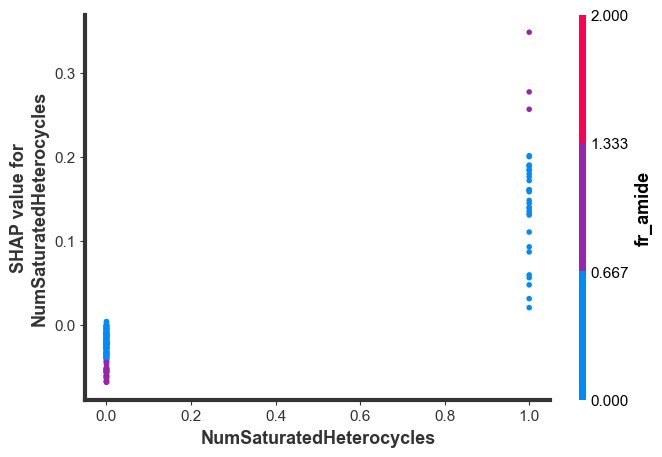

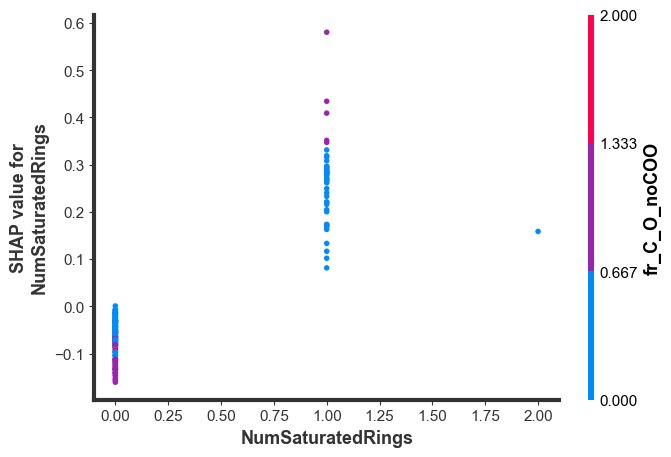

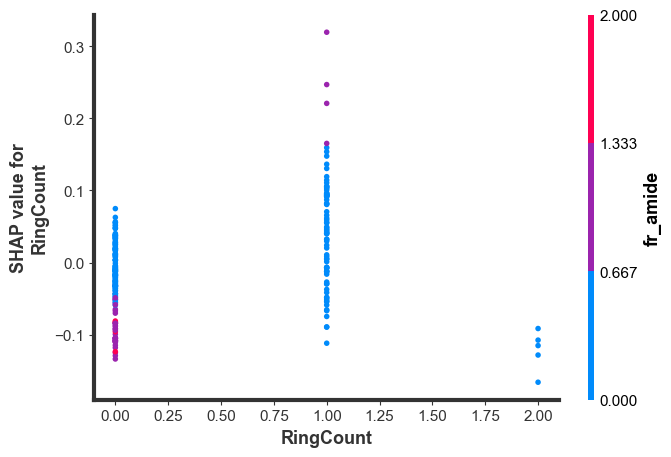

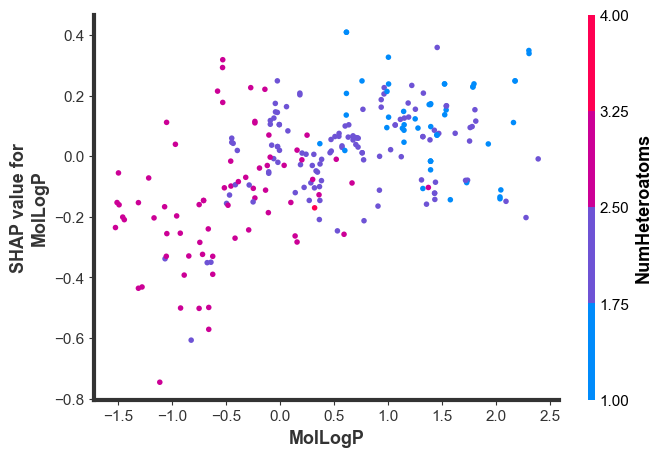

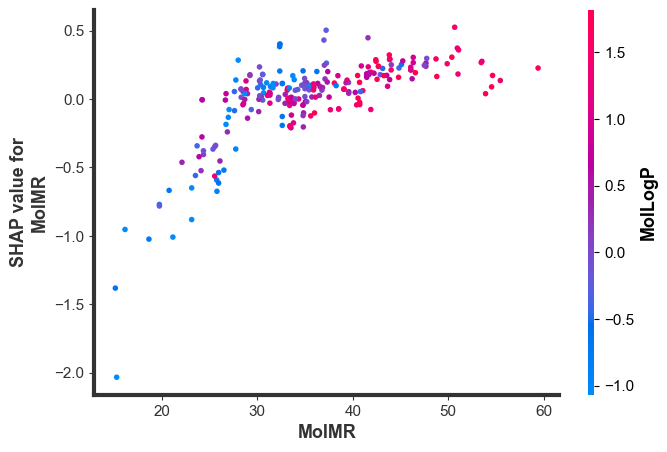

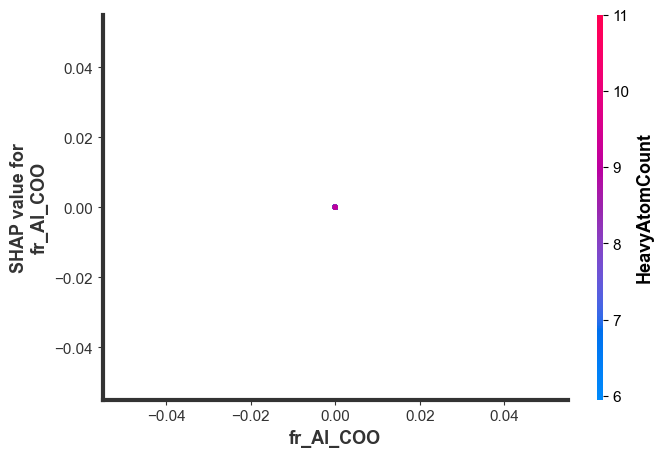

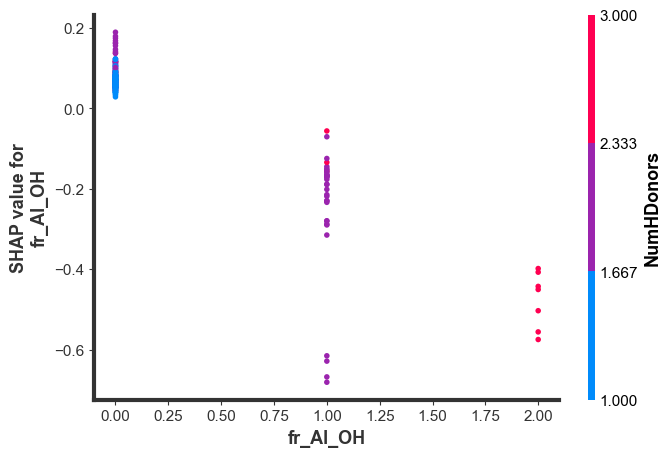

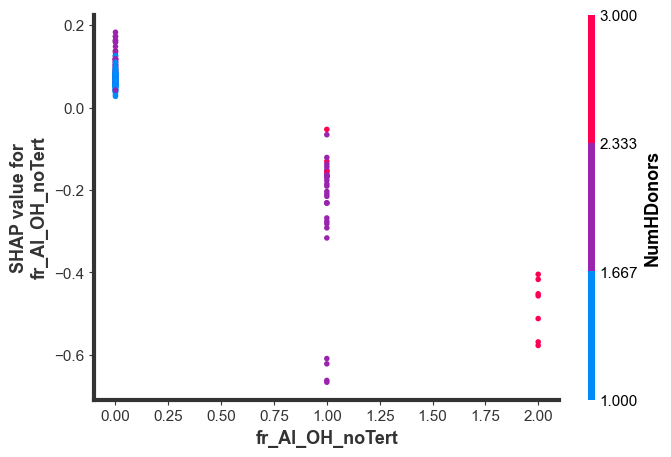

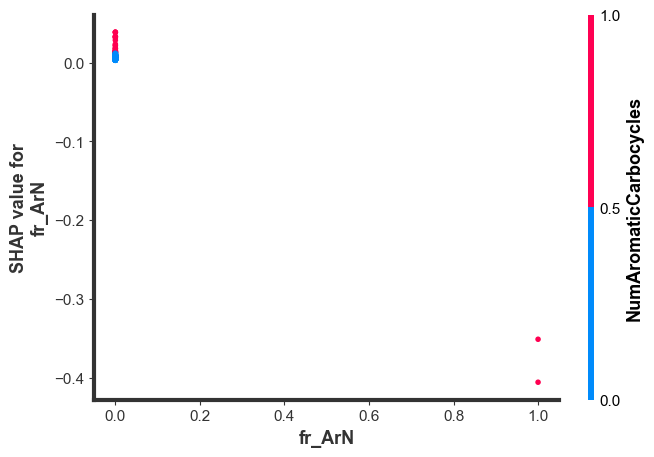

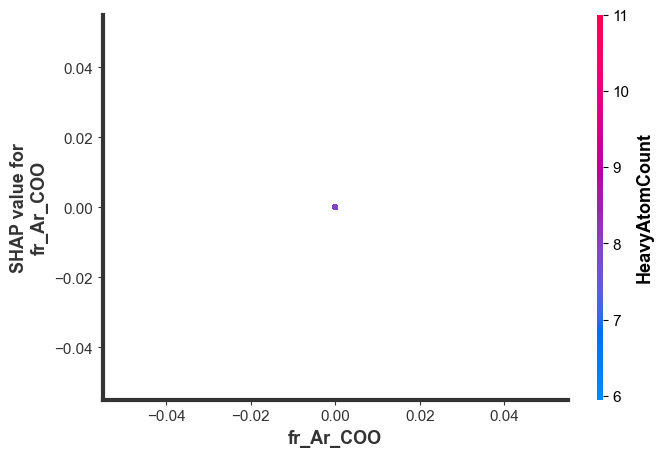

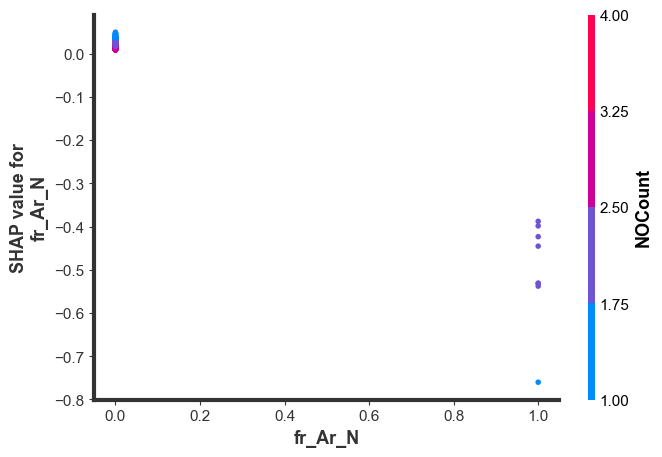

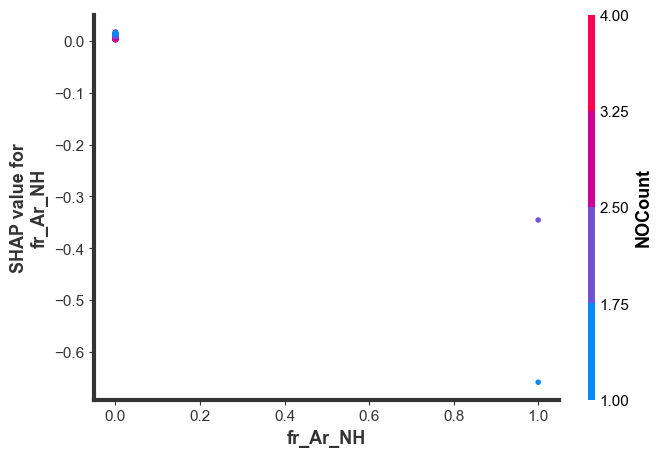

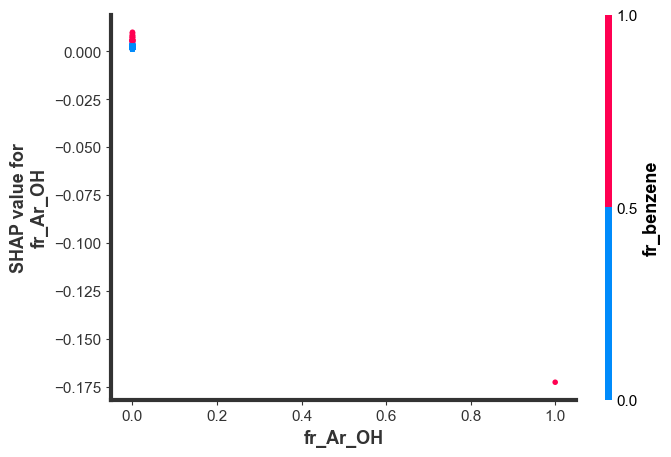

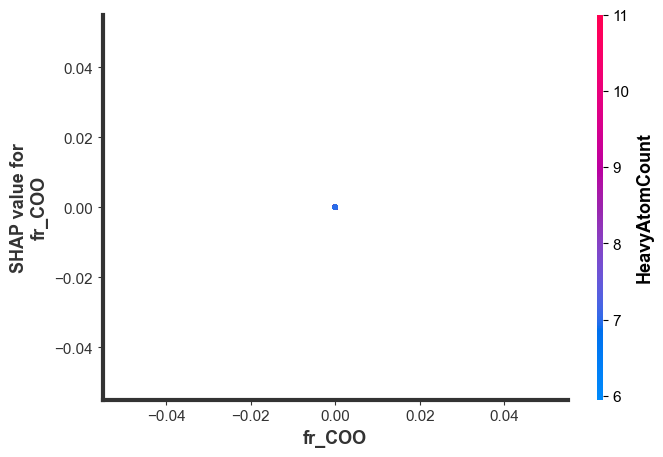

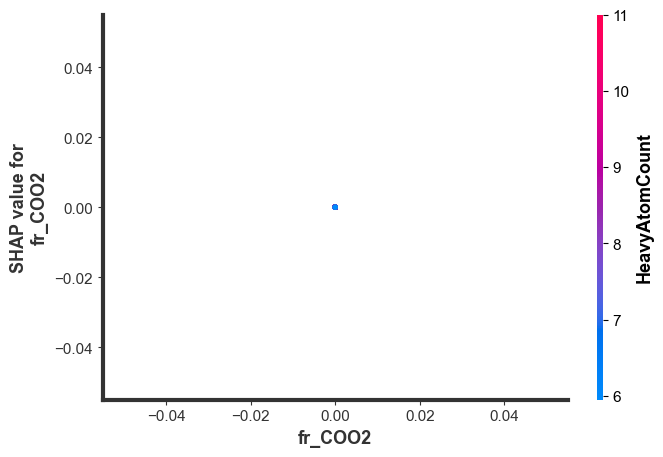

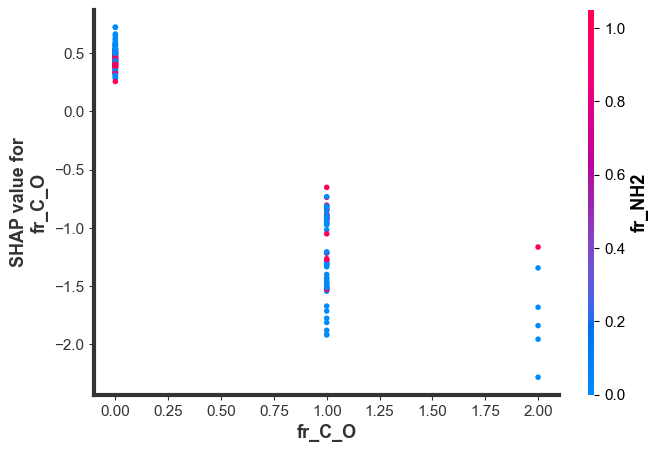

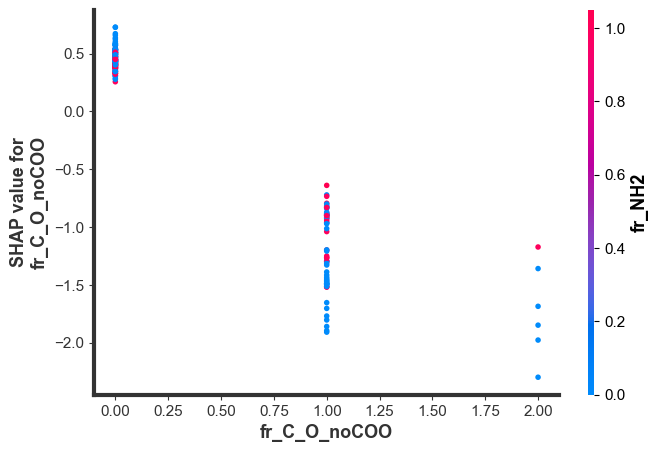

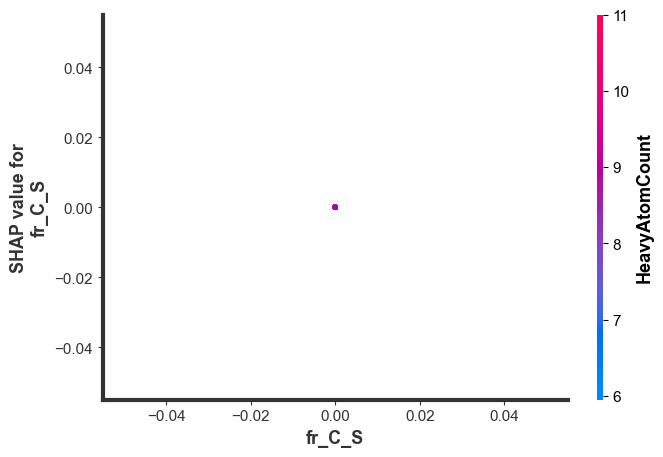

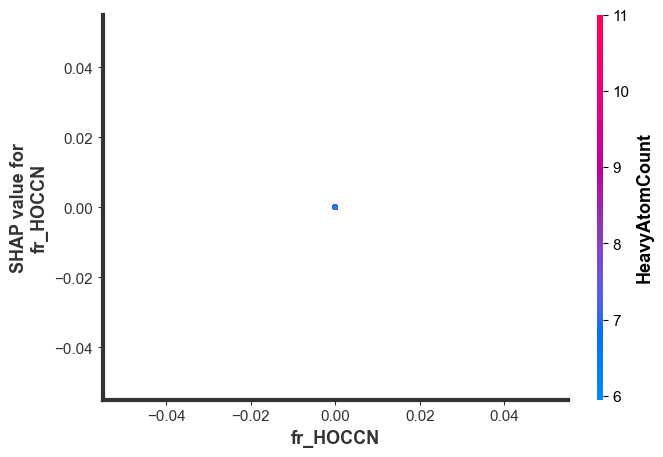

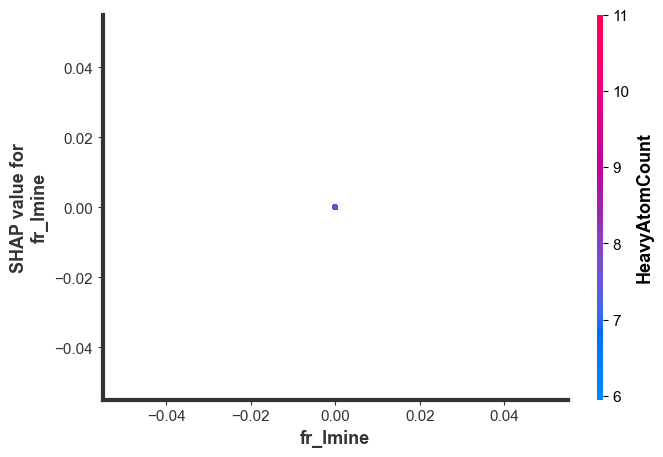

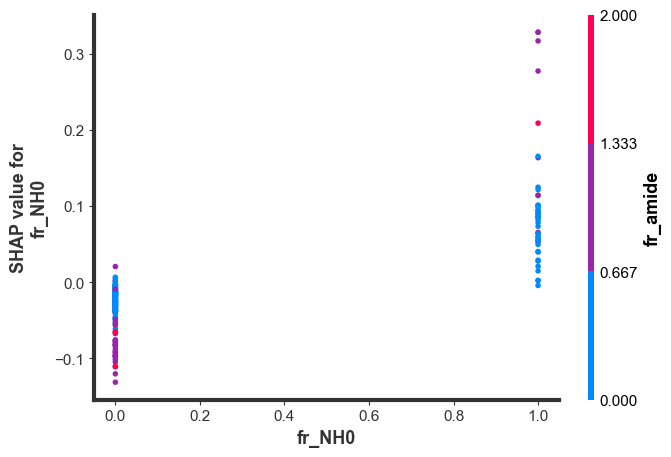

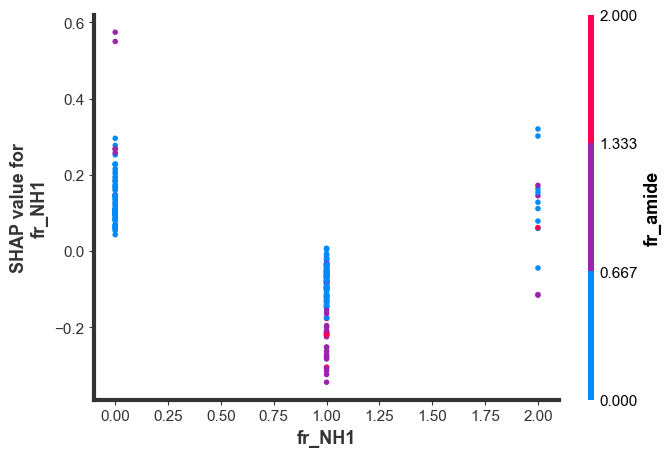

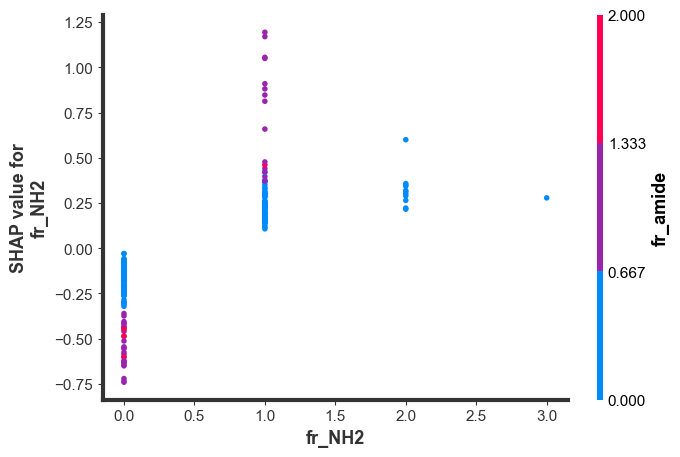

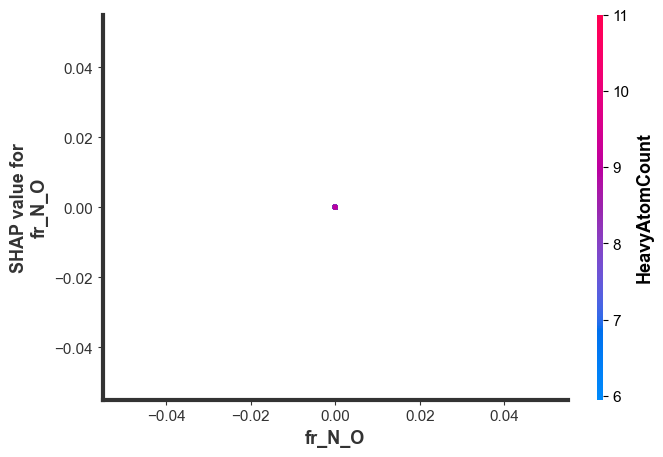

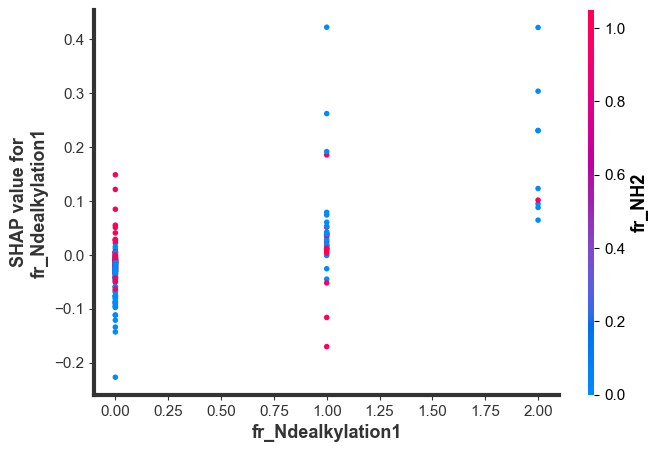

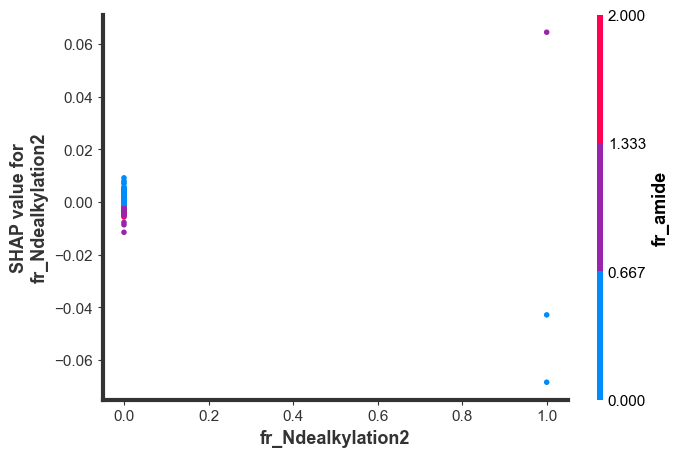

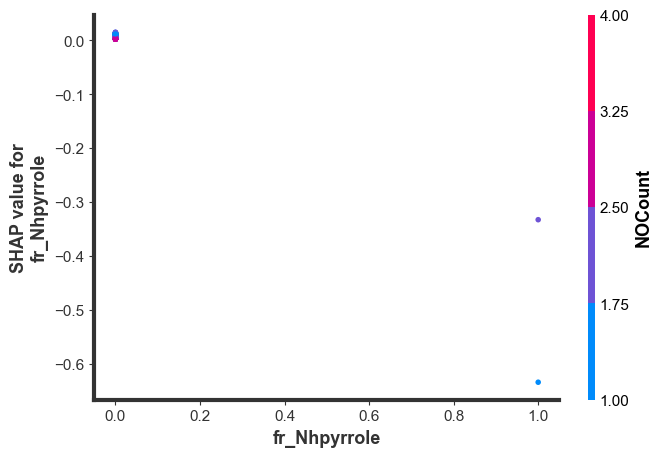

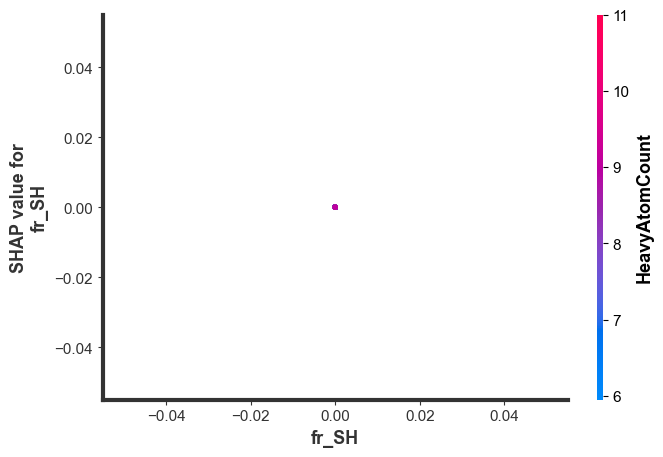

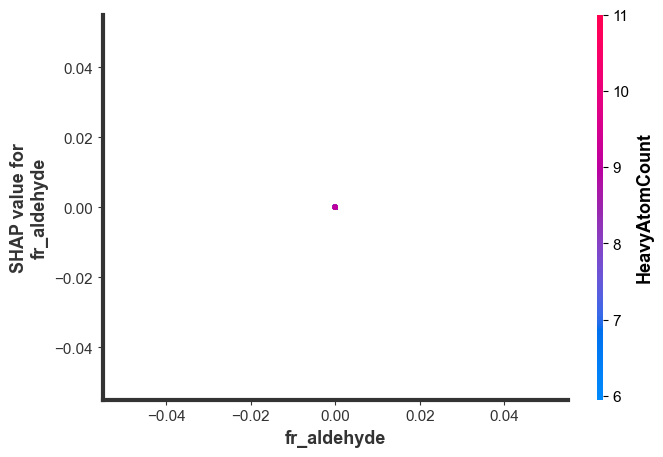

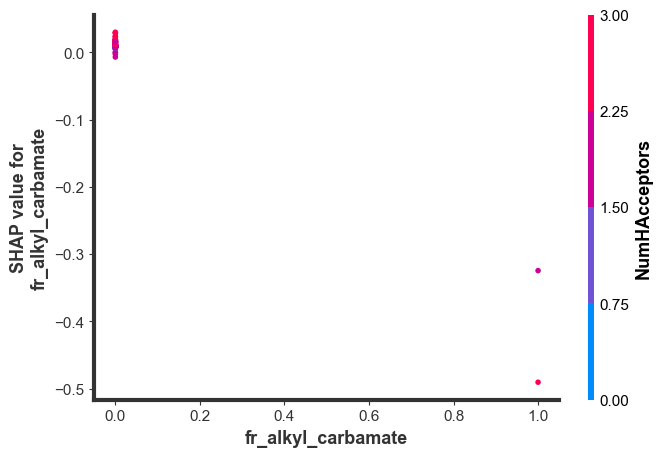

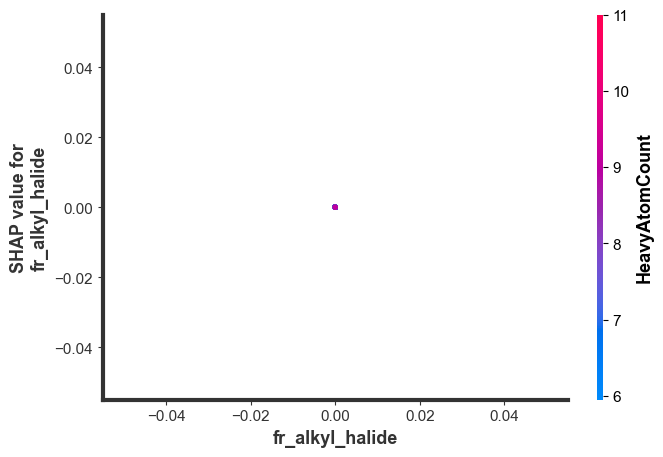

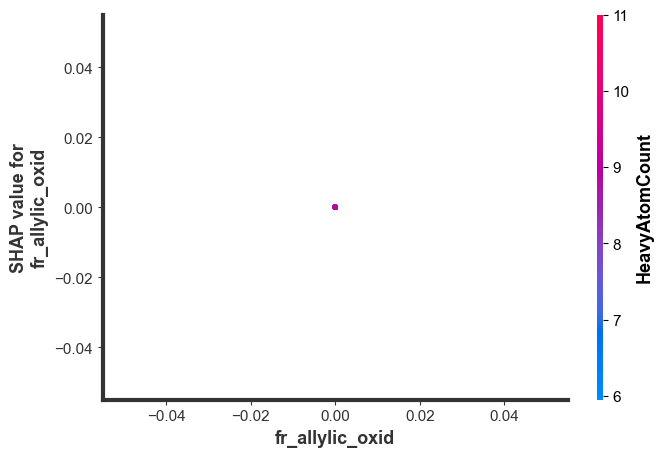

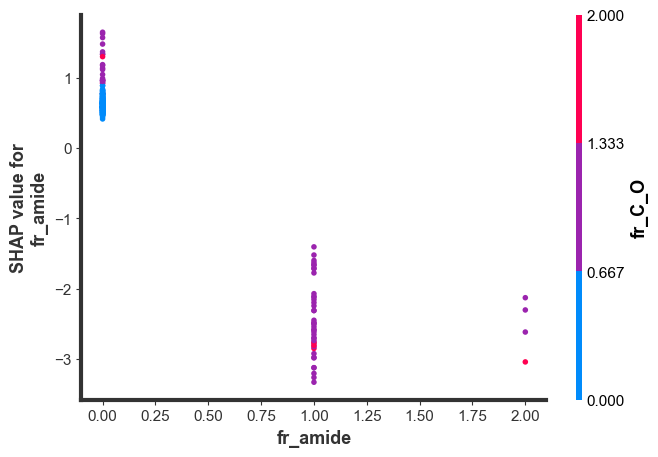

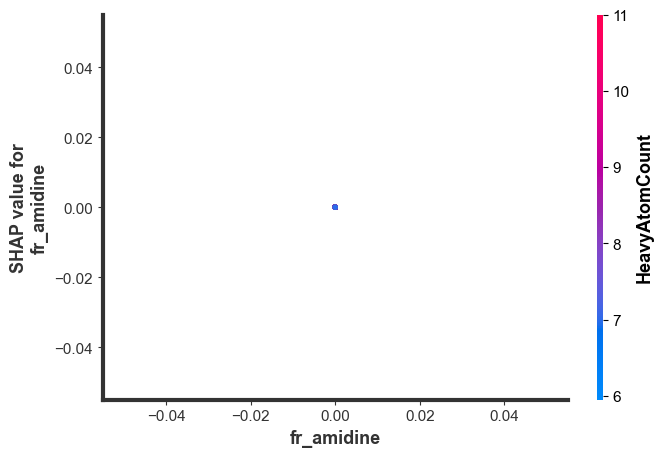

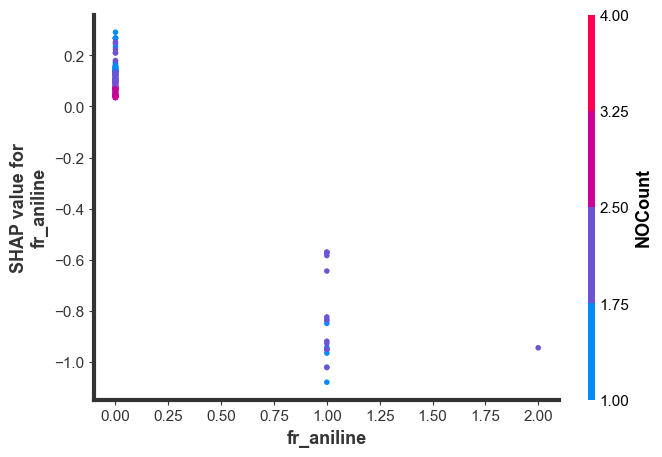

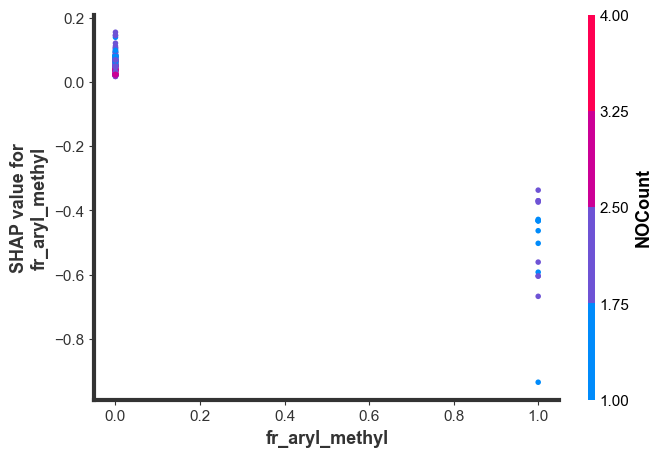

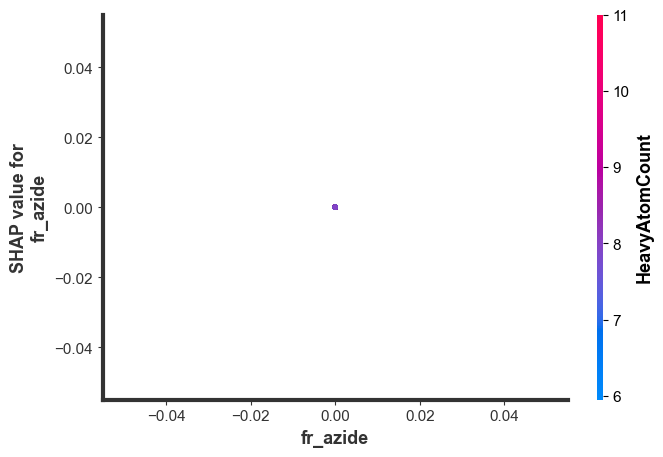

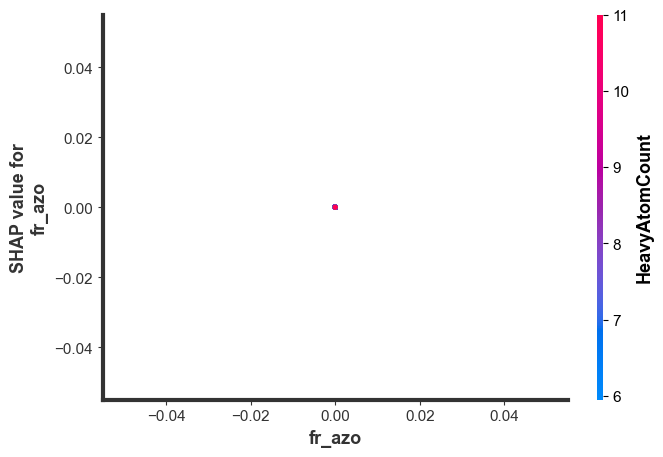

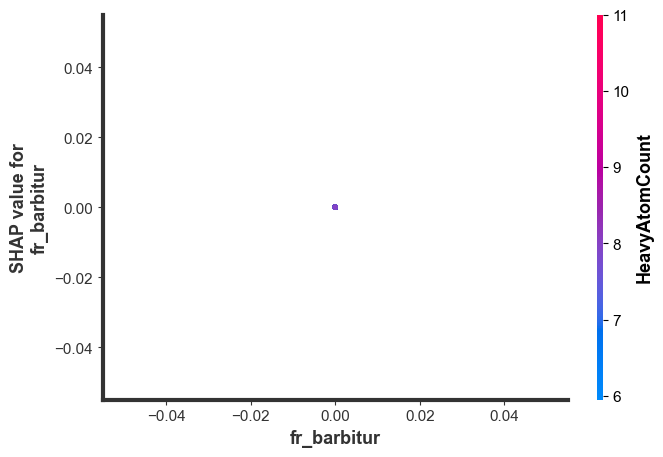

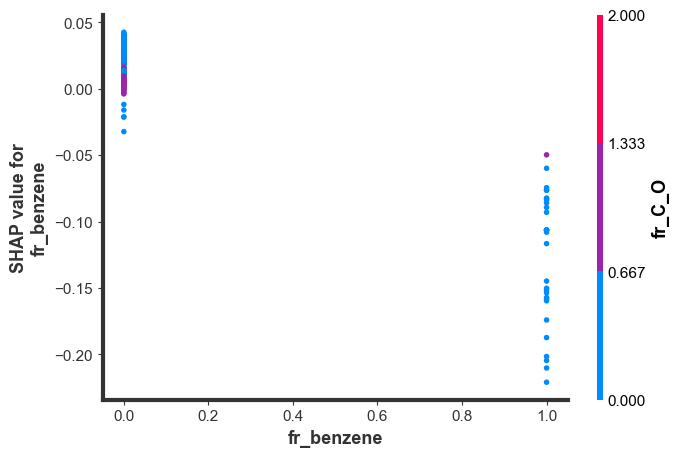

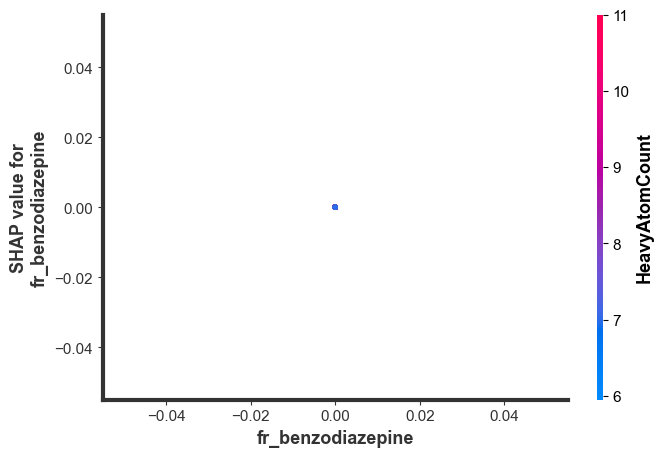

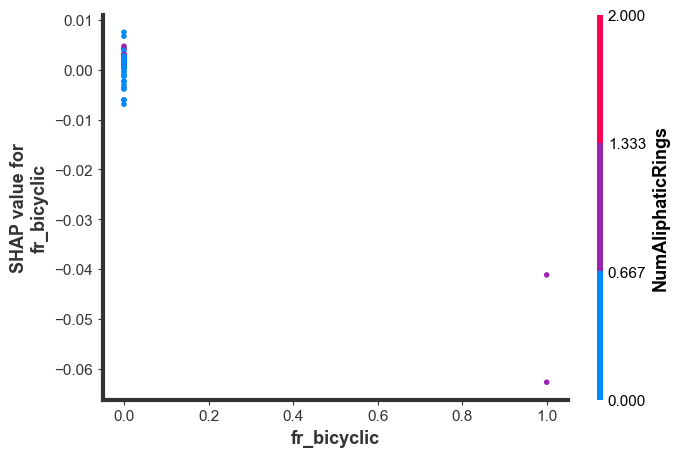

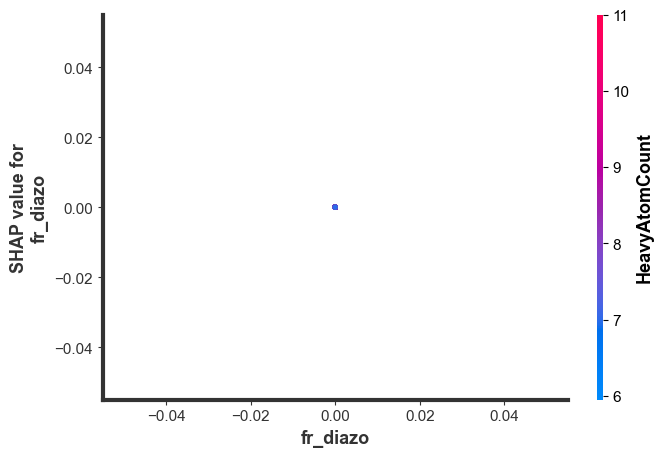

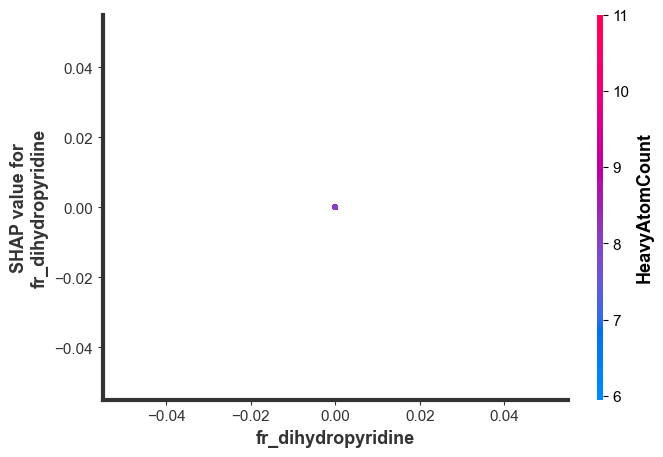

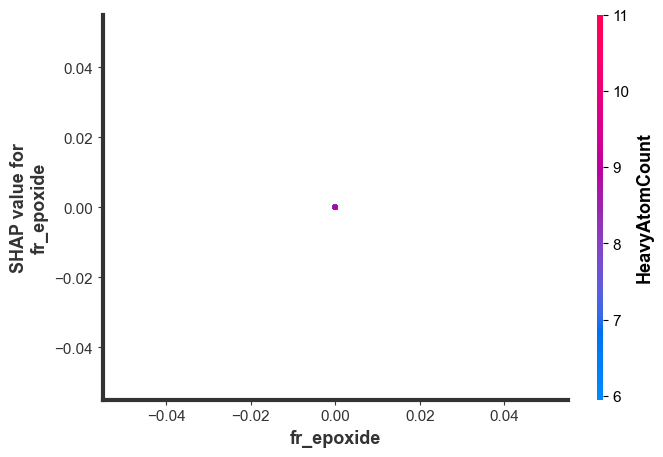

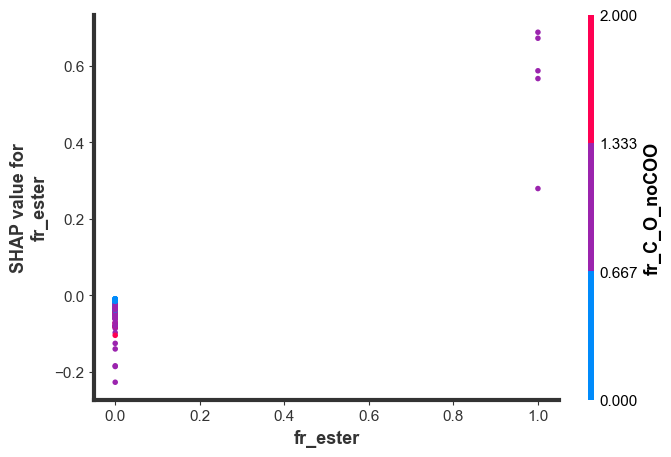

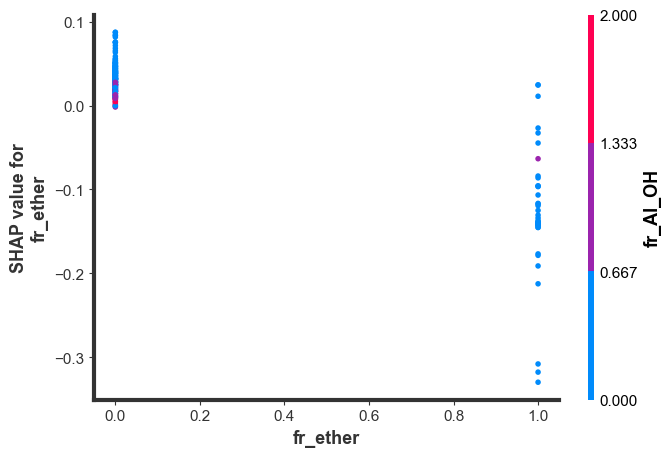

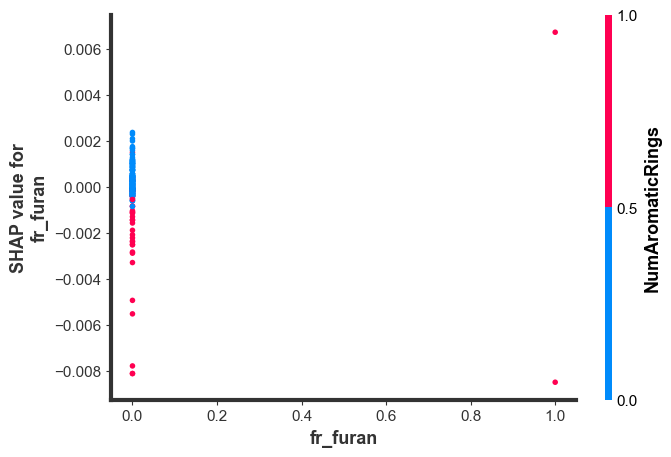

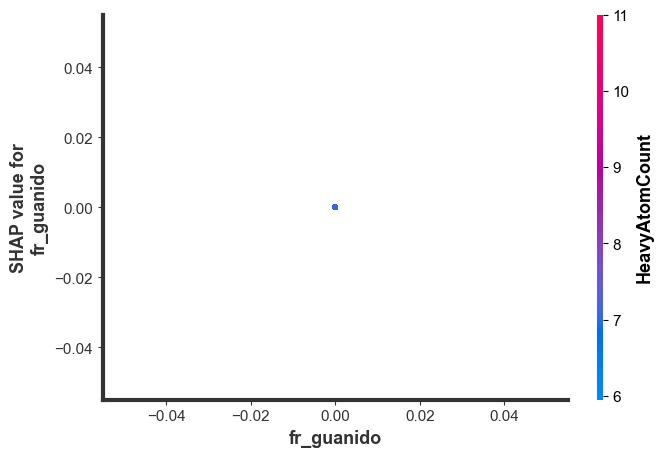

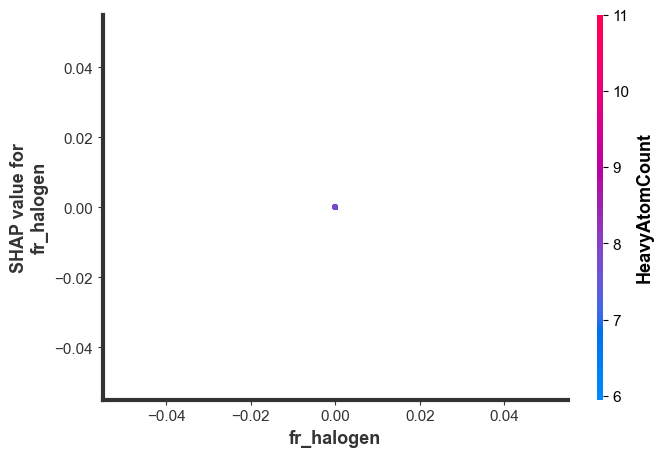

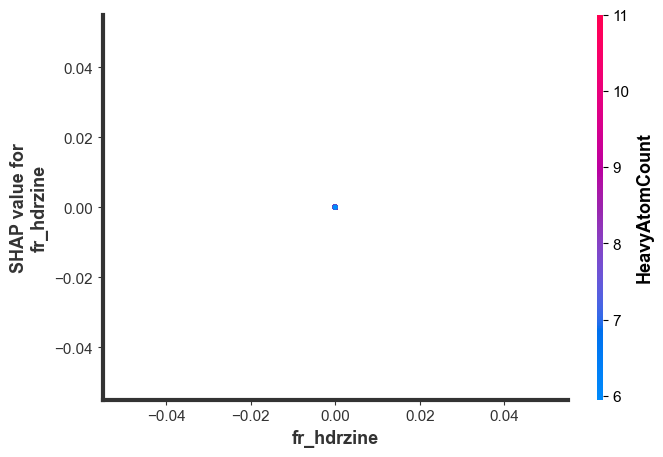

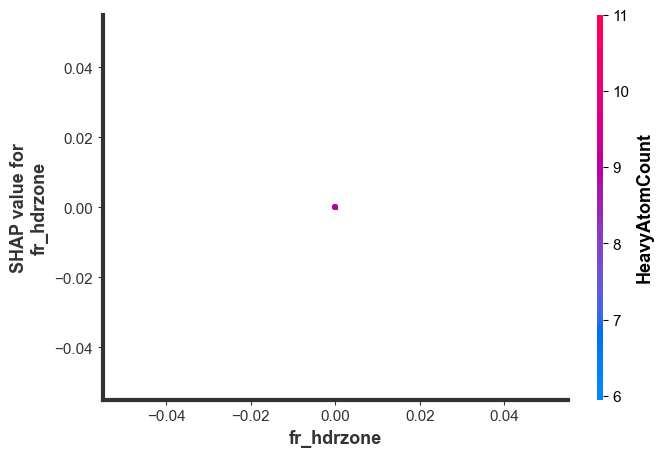

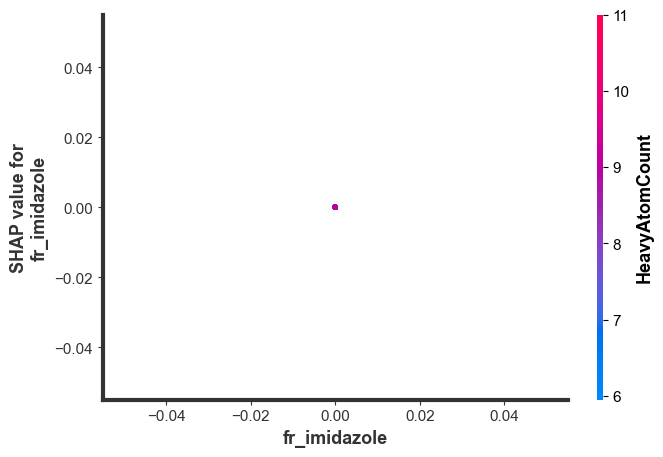

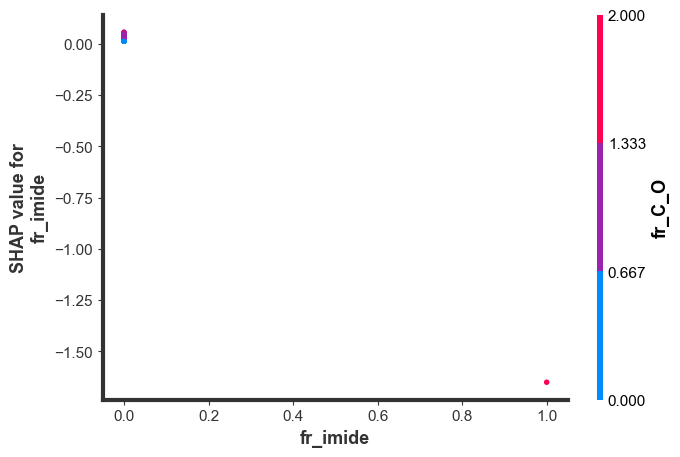

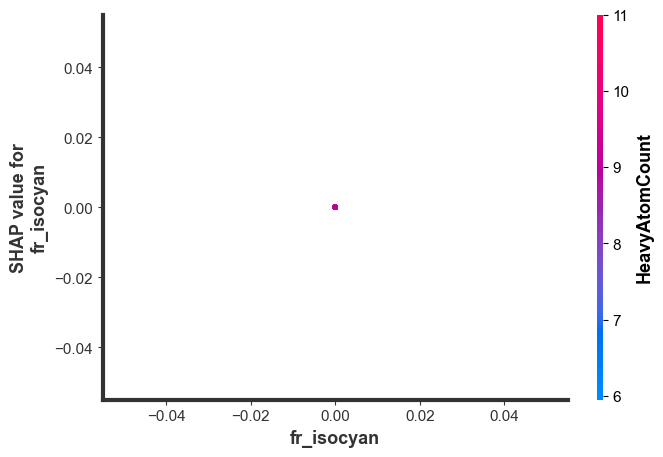

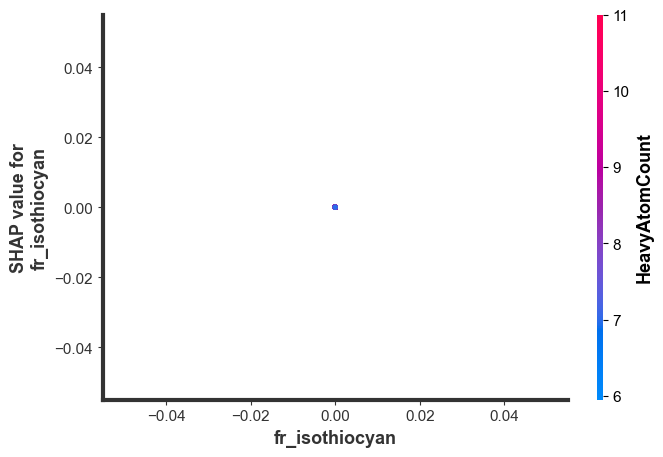

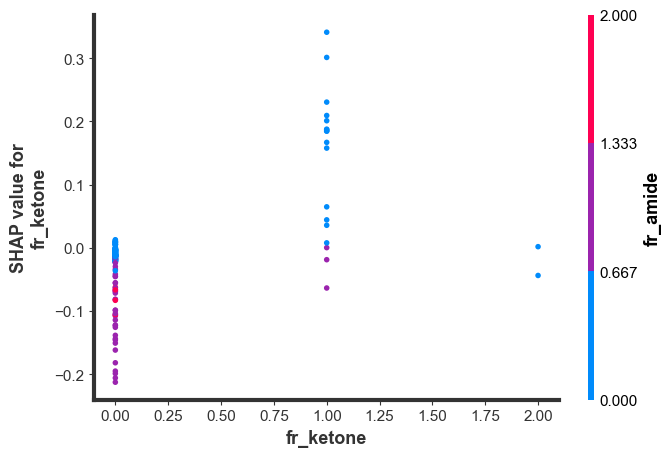

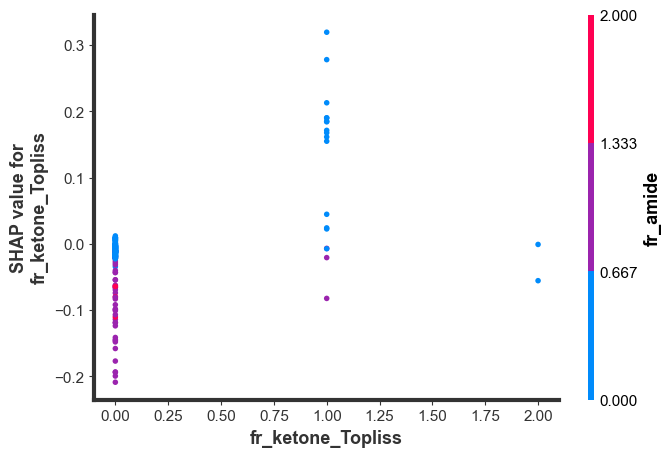

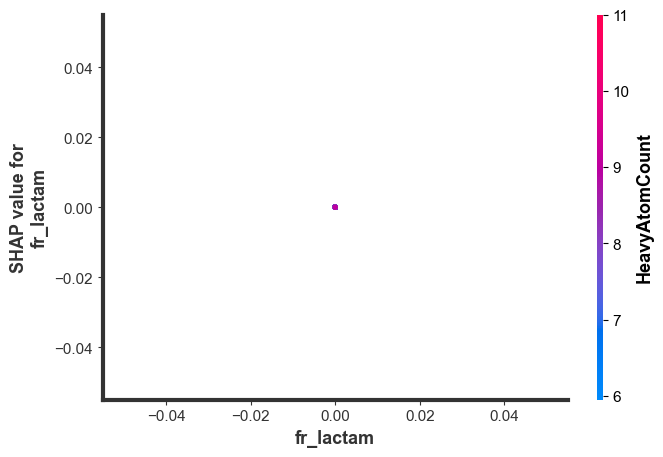

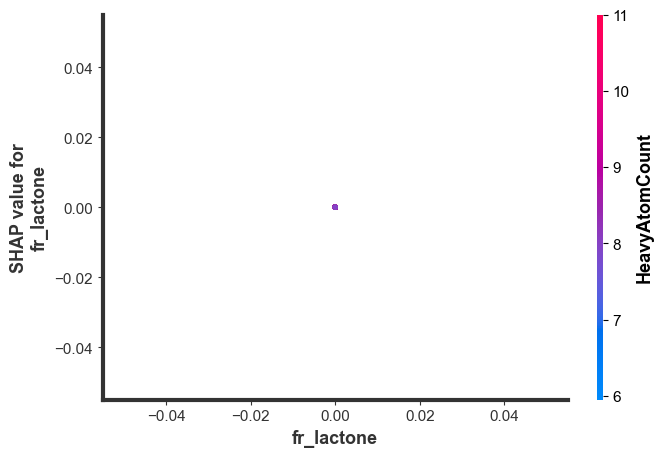

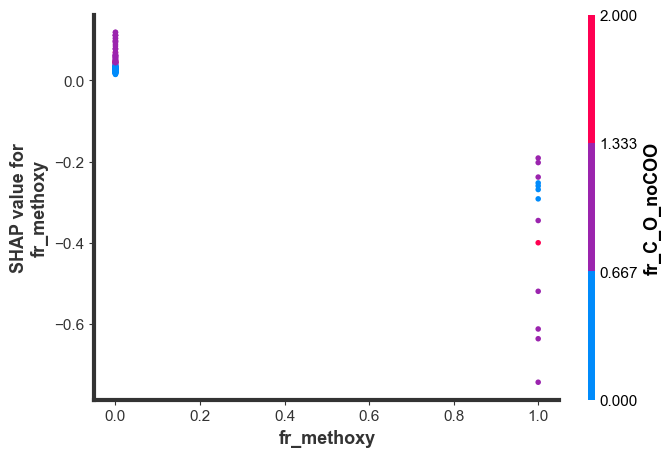

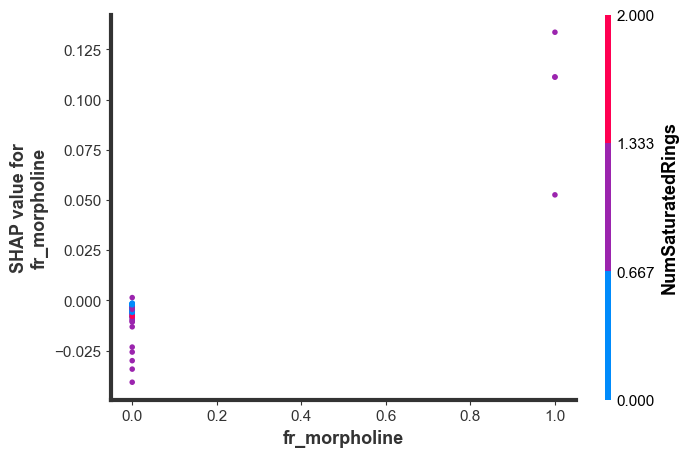

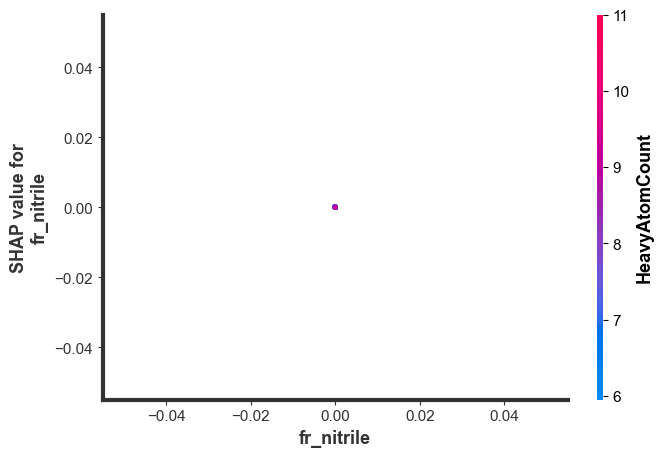

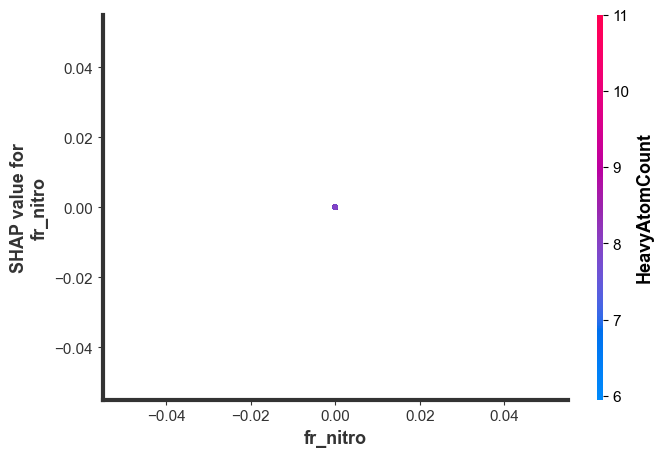

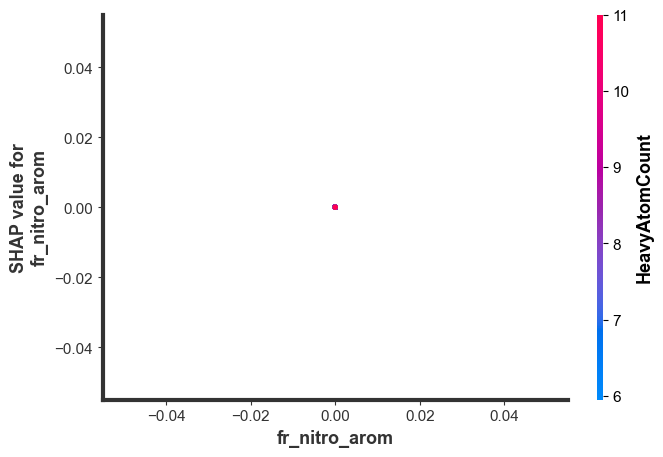

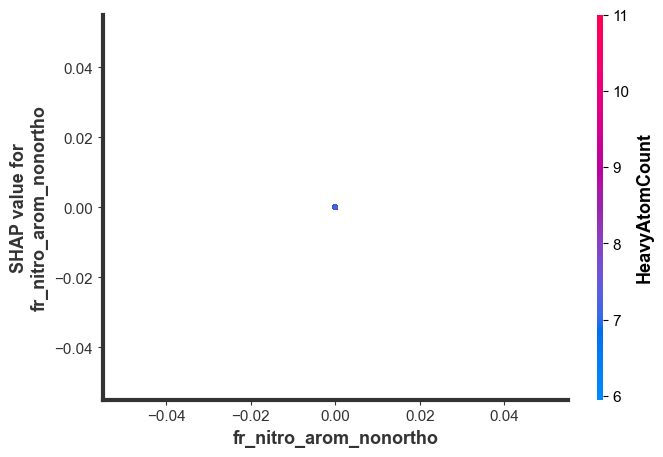

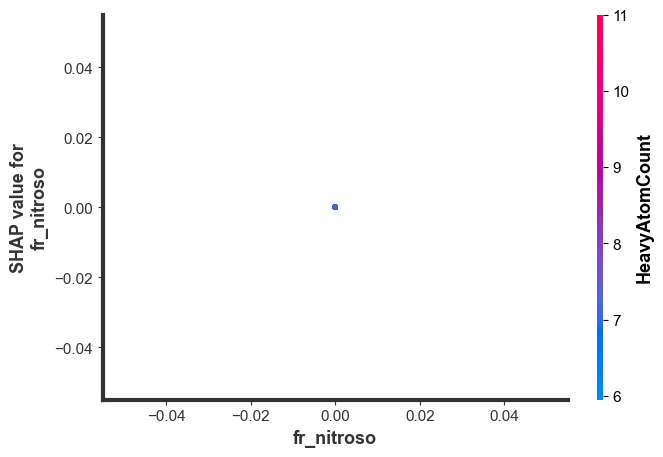

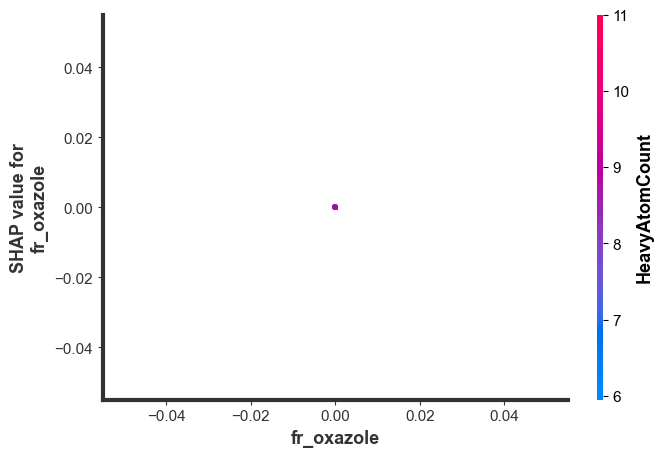

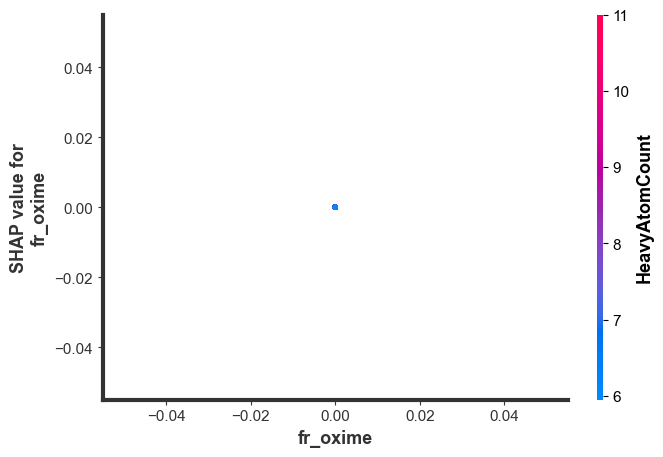

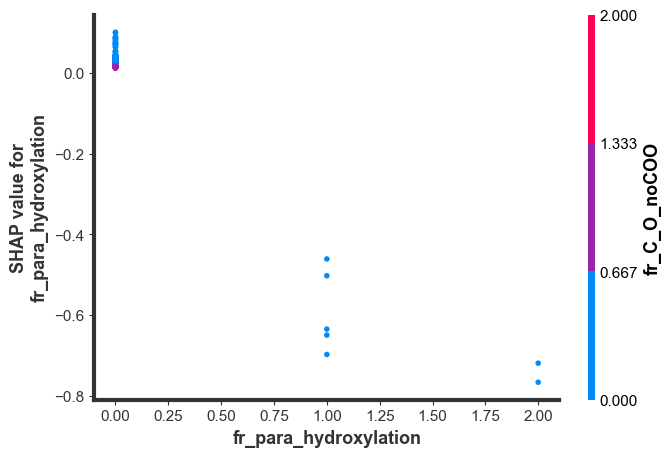

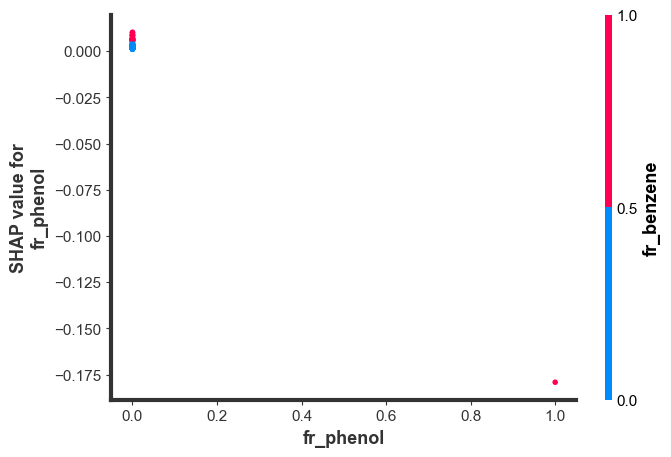

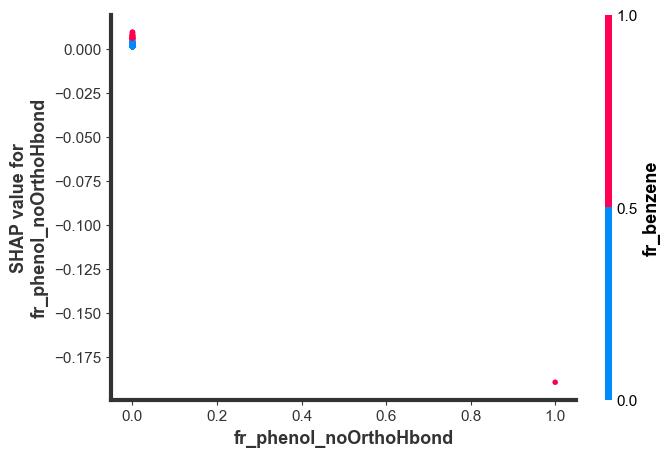

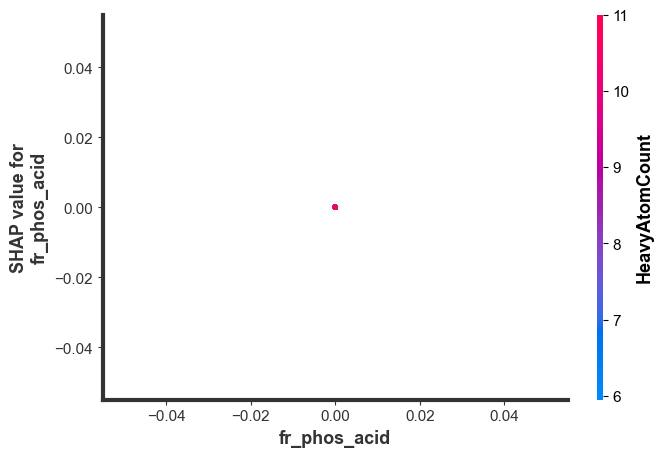

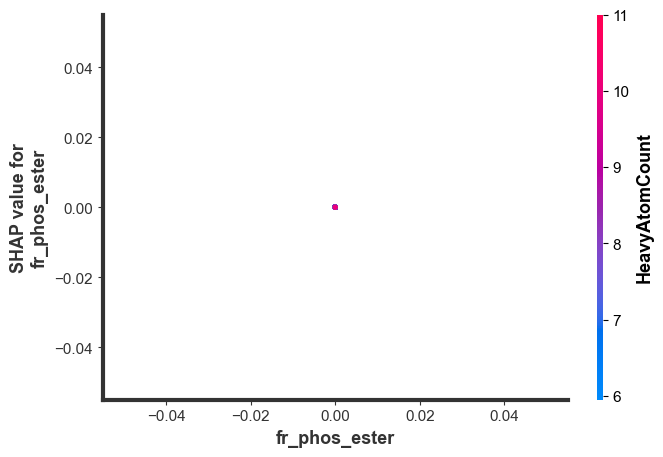

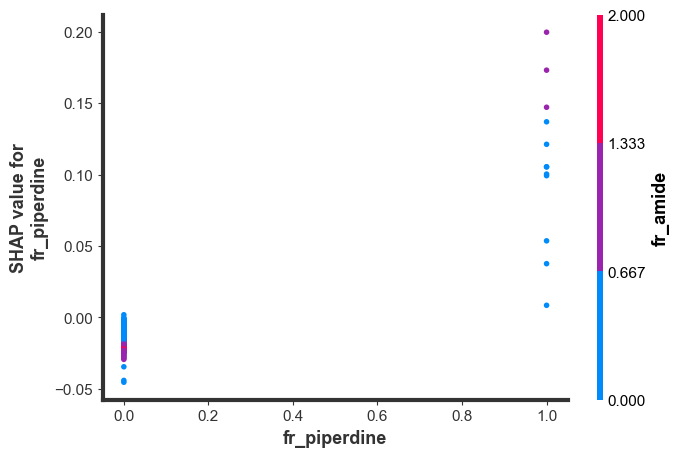

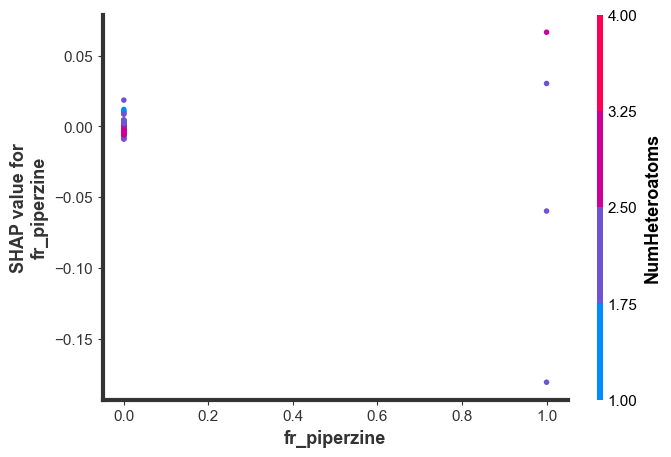

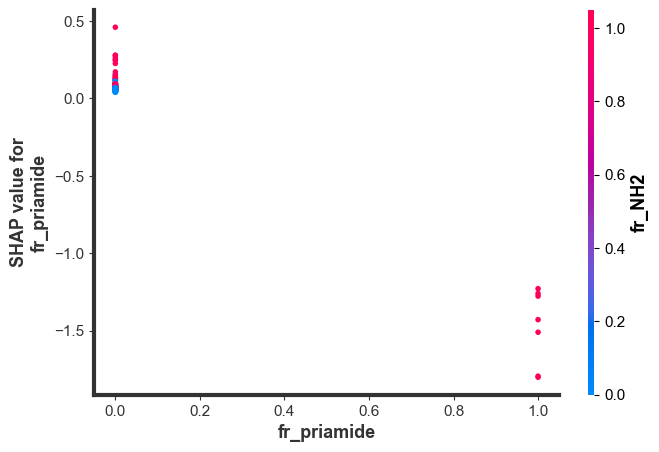

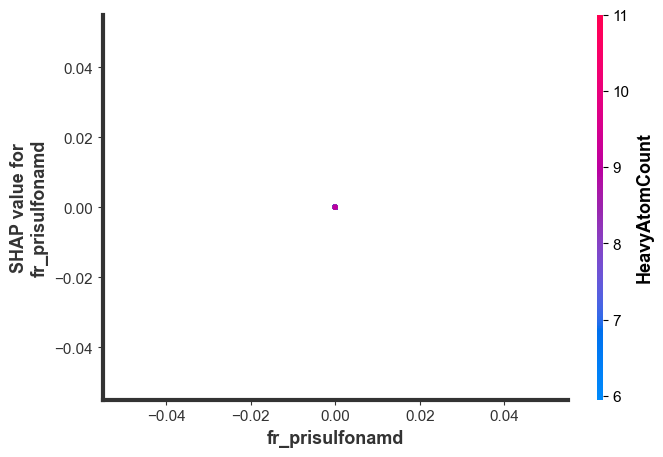

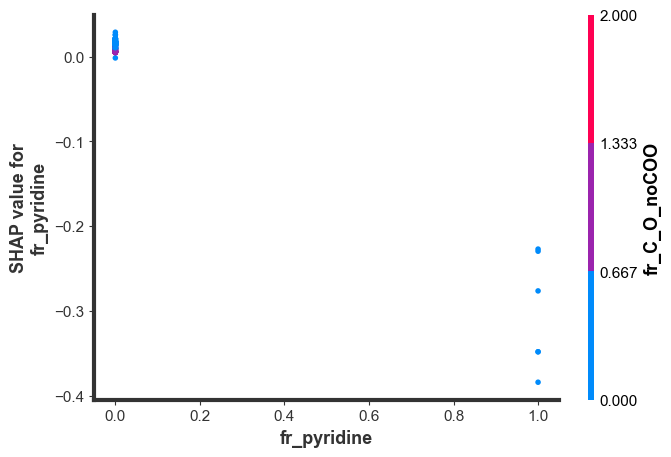

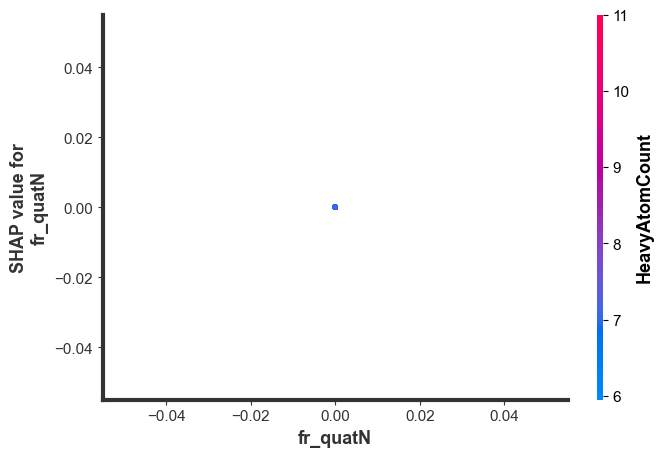

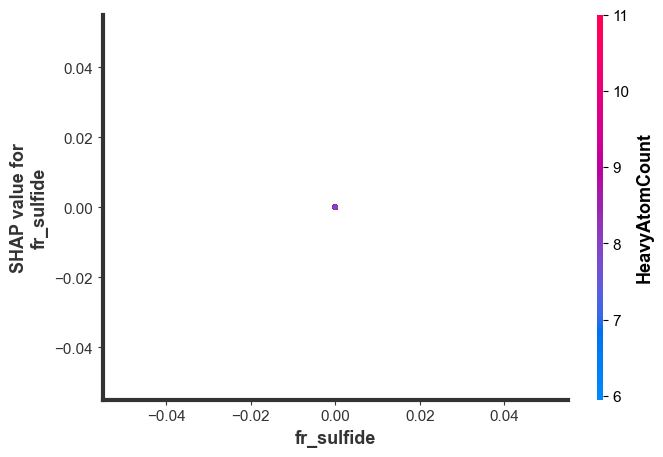

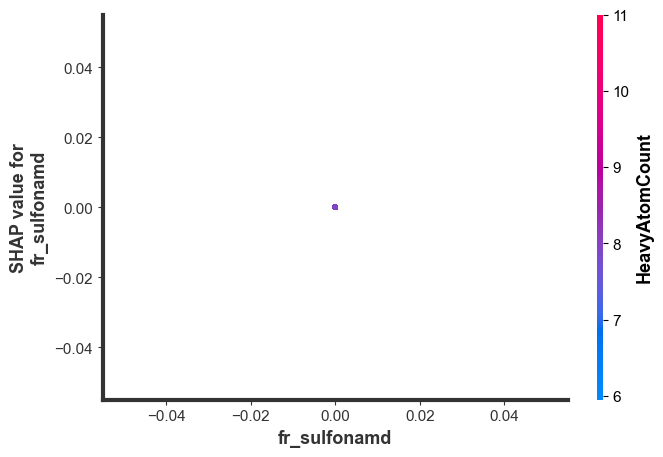

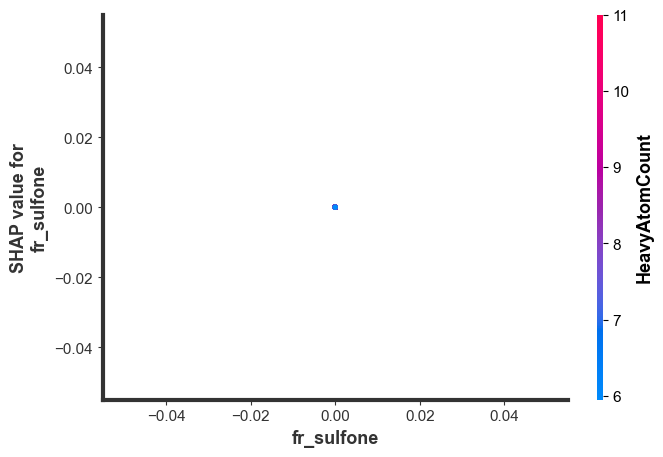

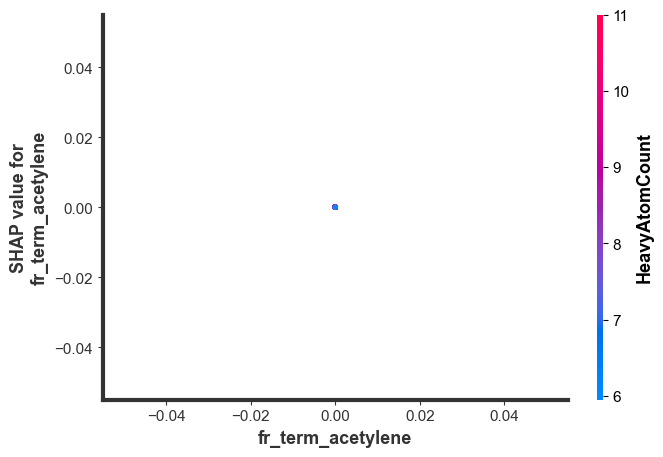

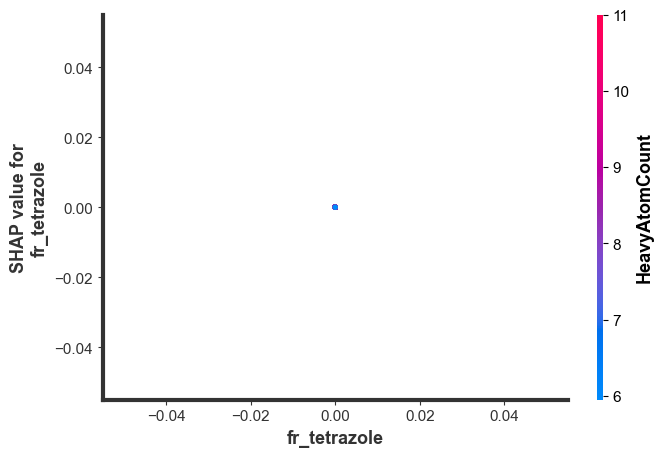

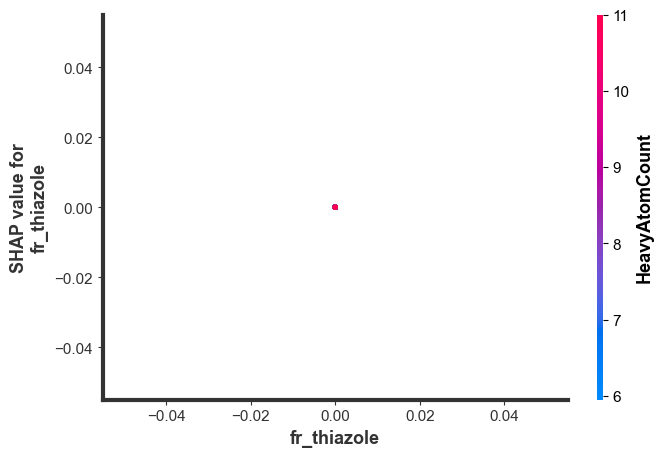

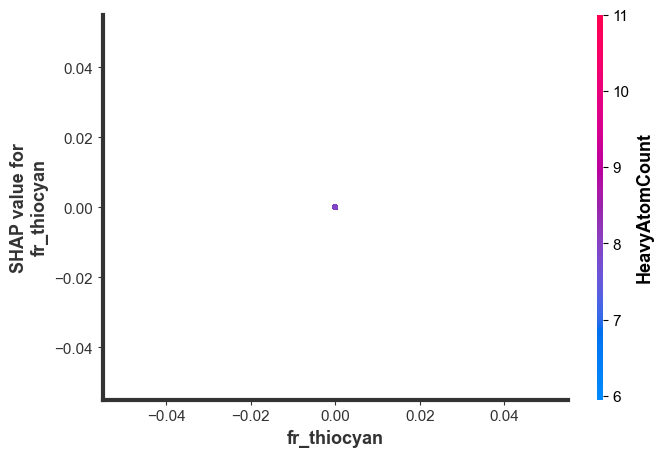

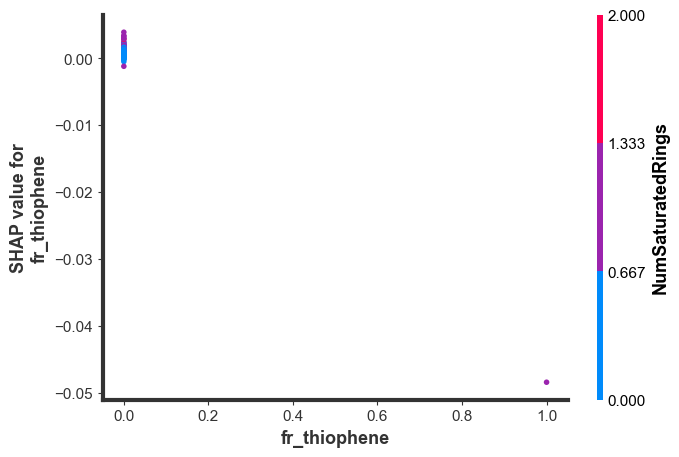

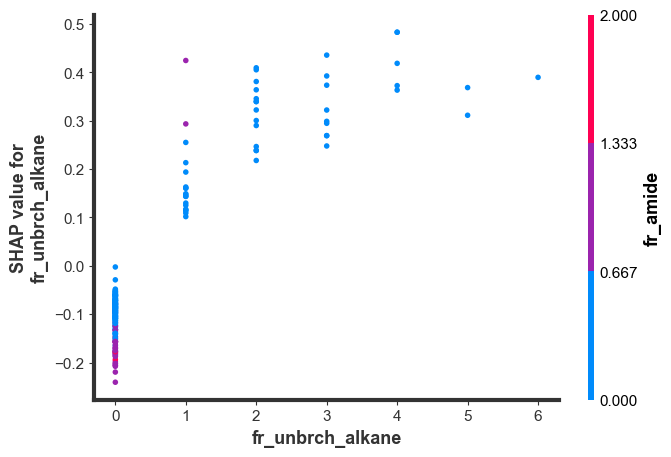

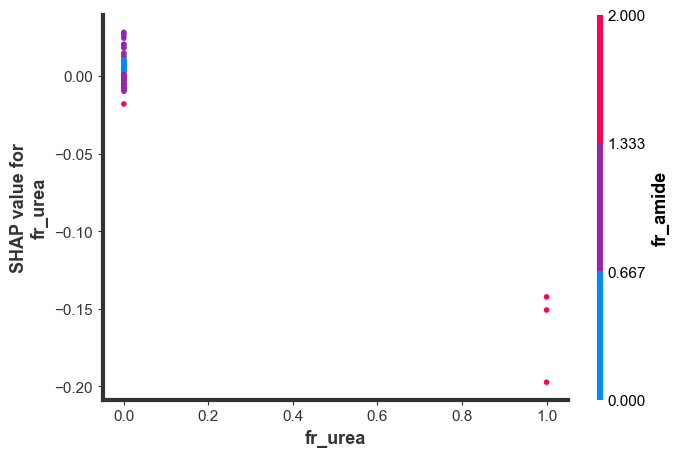

In [24]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train)


In [25]:
target_data = data['y']
# 最大
largest_item = target_data[target_data == target_data.max()].index[0]
# 最小
minest_item = target_data[target_data == target_data.min()].index[0]
# np.where(train_dataset['MeSH'] == 100)

In [27]:
max_diff_in_good_situation = 0
error_array = abs(y_train - model_xgb.predict(X_train))
worst_iloc_in_good_situation = 0
for i in range(len(y_train)):
    if error_array[i] > max_diff_in_good_situation and y_train[i] > 0.6:
        max_diff_in_good_situation = error_array[i]


for i in range(len(y_train)):
    if abs(error_array[i] - max_diff_in_good_situation) <= 0.0001:
        worst_iloc_in_good_situation=i
        
print(y_train[worst_iloc_in_good_situation])
print(model_xgb.predict(X_train)[worst_iloc_in_good_situation])

print(X_train.iloc[worst_iloc_in_good_situation])

-5.285483196
-5.433982558280852
HeavyAtomCount              6.0
NHOHCount                   1.0
NOCount                     1.0
NumAliphaticCarbocycles     0.0
NumAliphaticHeterocycles    1.0
                           ... 
fr_thiazole                 0.0
fr_thiocyan                 0.0
fr_thiophene                0.0
fr_unbrch_alkane            0.0
fr_urea                     0.0
Name: CC1CCNC1, Length: 104, dtype: float64


In [28]:
max_diff = abs(y_train - model_xgb.predict(X_train)).max()
error_array = abs(y_train - model_xgb.predict(X_train))
worst_iloc=-1
for i in range(len(y_train)):
    if abs(error_array[i] - max_diff) <= 0.0001:
        worst_iloc=i
        
# print(y_train[worst_iloc])
# print(model_xgb.predict(X_train)[worst_iloc])

print(X_train.iloc[worst_iloc])

HeavyAtomCount              8.0
NHOHCount                   1.0
NOCount                     3.0
NumAliphaticCarbocycles     0.0
NumAliphaticHeterocycles    0.0
                           ... 
fr_thiazole                 0.0
fr_thiocyan                 0.0
fr_thiophene                0.0
fr_unbrch_alkane            0.0
fr_urea                     0.0
Name: CNCC(=O)N(C)C, Length: 104, dtype: float64


In [29]:
min_diff = abs(y_train - model_xgb.predict(X_train)).min()
best_iloc=-1
for i in range(len(y_train)):
    if abs(error_array[i] - min_diff) <= 0.0001:
        best_iloc=i
        
print(y_train[best_iloc])
print(model_xgb.predict(X_train)[best_iloc])

print(data.iloc[best_iloc])

-6.392547247
-6.389132783297952
HeavyAtomCount              8.000000
NHOHCount                   2.000000
NOCount                     2.000000
NumAliphaticCarbocycles     0.000000
NumAliphaticHeterocycles    1.000000
                              ...   
fr_thiocyan                 0.000000
fr_thiophene                0.000000
fr_unbrch_alkane            0.000000
fr_urea                     0.000000
y                          -6.392547
Name: C1CNCCCNC1, Length: 105, dtype: float64


HeavyAtomCount              8.0
NHOHCount                   2.0
NOCount                     2.0
NumAliphaticCarbocycles     0.0
NumAliphaticHeterocycles    1.0
                           ... 
fr_thiazole                 0.0
fr_thiocyan                 0.0
fr_thiophene                0.0
fr_unbrch_alkane            0.0
fr_urea                     0.0
Name: C1CNCCCNC1, Length: 104, dtype: float64
-6.392547247


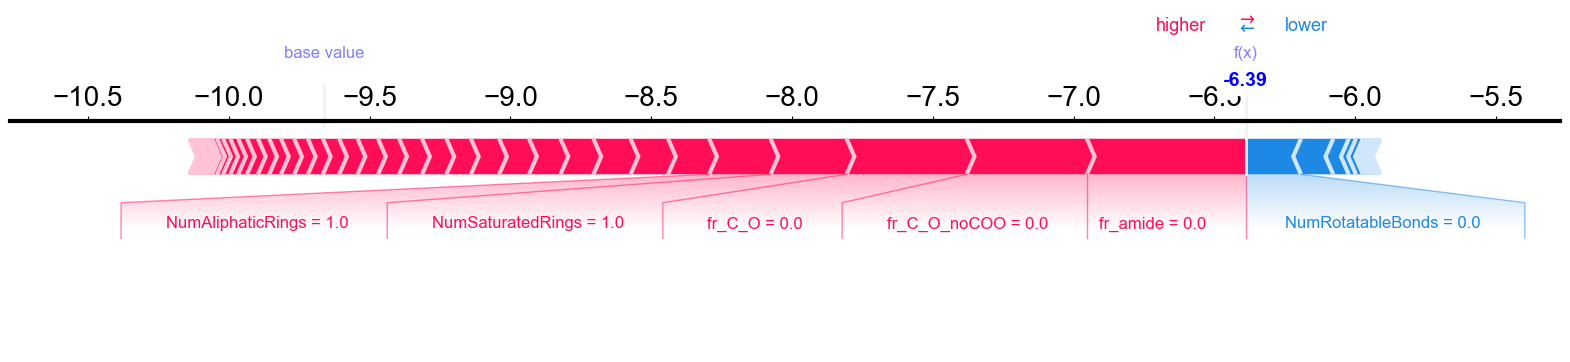

In [30]:
mpl.rcParams['font.size'] = 20

# 最大的值
shap.initjs()
print(train_dataset[feature_column].iloc[best_iloc])
print(train_dataset['y'].iloc[best_iloc])
shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc],matplotlib=True) 

shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc])


HeavyAtomCount              8.0
NHOHCount                   2.0
NOCount                     2.0
NumAliphaticCarbocycles     0.0
NumAliphaticHeterocycles    1.0
                           ... 
fr_thiazole                 0.0
fr_thiocyan                 0.0
fr_thiophene                0.0
fr_unbrch_alkane            0.0
fr_urea                     0.0
Name: C1CNCCCNC1, Length: 104, dtype: float64
-6.392547247


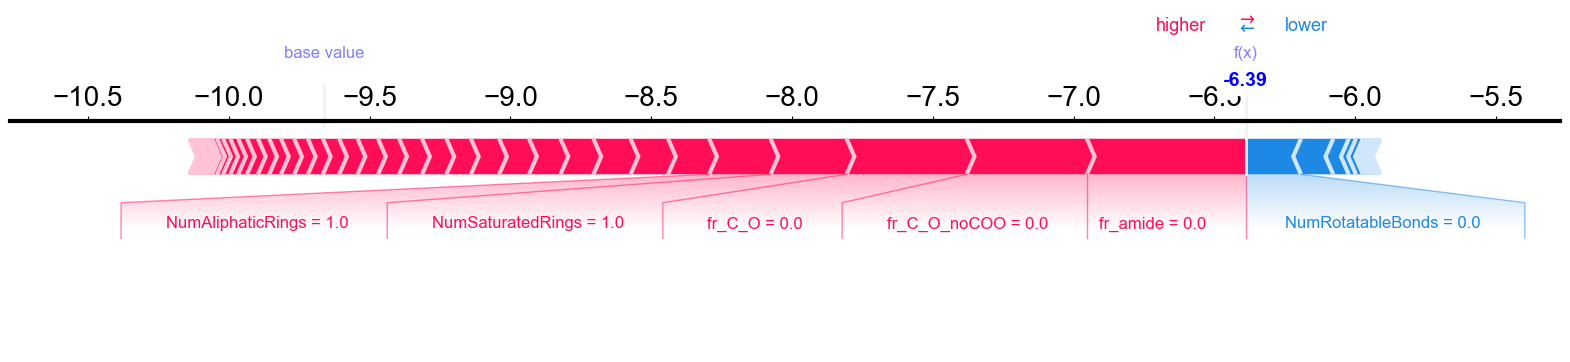

In [31]:
shap.initjs()
print(train_dataset[feature_column].iloc[best_iloc])
print(train_dataset['y'].iloc[best_iloc])

shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc])
shap.force_plot(explainer.expected_value, shap_values[best_iloc], train_dataset[feature_column].iloc[best_iloc],matplotlib=True)

HeavyAtomCount              8.0
NHOHCount                   1.0
NOCount                     3.0
NumAliphaticCarbocycles     0.0
NumAliphaticHeterocycles    0.0
                           ... 
fr_thiazole                 0.0
fr_thiocyan                 0.0
fr_thiophene                0.0
fr_unbrch_alkane            0.0
fr_urea                     0.0
Name: CNCC(=O)N(C)C, Length: 104, dtype: float64


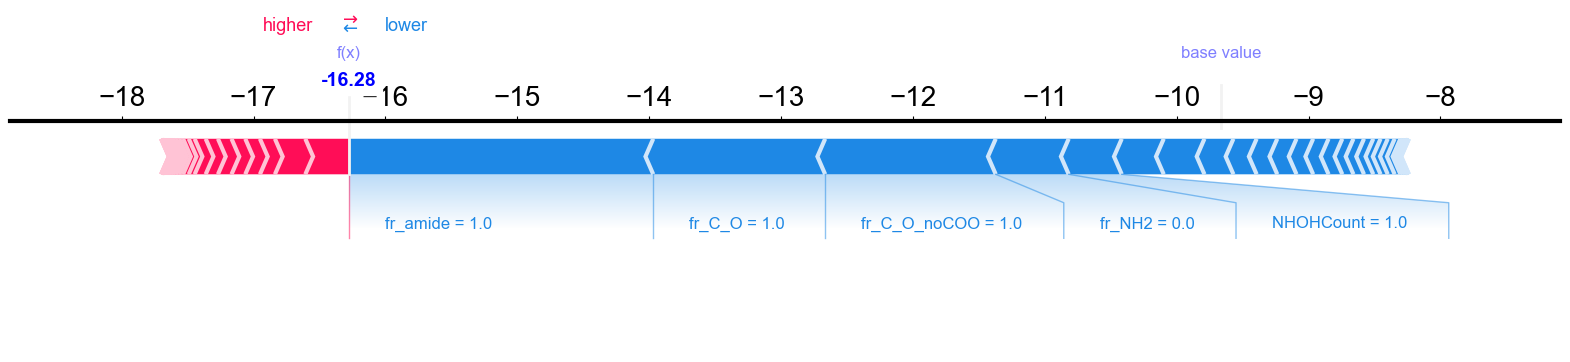

In [32]:
shap.initjs()
print(train_dataset[feature_column].iloc[worst_iloc])
shap.force_plot(explainer.expected_value, shap_values[worst_iloc], train_dataset[feature_column].iloc[worst_iloc])
shap.force_plot(explainer.expected_value, shap_values[worst_iloc], train_dataset[feature_column].iloc[worst_iloc],matplotlib=True)


HeavyAtomCount              6.0
NHOHCount                   1.0
NOCount                     1.0
NumAliphaticCarbocycles     0.0
NumAliphaticHeterocycles    1.0
                           ... 
fr_thiazole                 0.0
fr_thiocyan                 0.0
fr_thiophene                0.0
fr_unbrch_alkane            0.0
fr_urea                     0.0
Name: CC1CCNC1, Length: 104, dtype: float64
-5.285483196


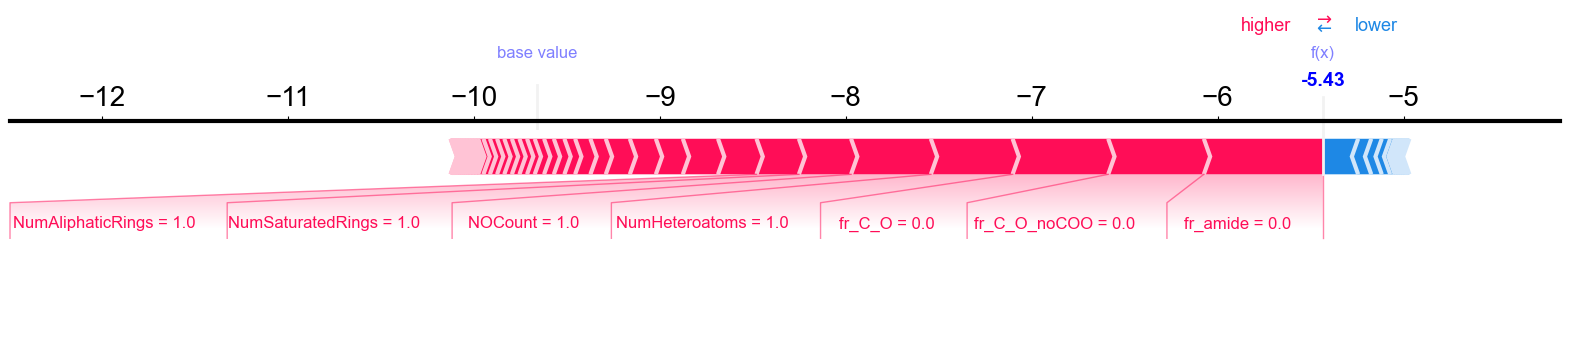

In [33]:

shap.initjs()
print(train_dataset[feature_column].iloc[worst_iloc_in_good_situation])
print(train_dataset['y'].iloc[worst_iloc_in_good_situation])
shap.force_plot(explainer.expected_value, shap_values[worst_iloc_in_good_situation], train_dataset[feature_column].iloc[worst_iloc_in_good_situation],matplotlib=True) 
shap.force_plot(explainer.expected_value, shap_values[worst_iloc_in_good_situation], train_dataset[feature_column].iloc[worst_iloc_in_good_situation]) 



In [34]:
# train_dataset[feature_column].loc["C1CNCCC1CN"]


HeavyAtomCount              8.0
NHOHCount                   2.0
NOCount                     2.0
NumAliphaticCarbocycles     0.0
NumAliphaticHeterocycles    1.0
                           ... 
fr_thiazole                 0.0
fr_thiocyan                 0.0
fr_thiophene                0.0
fr_unbrch_alkane            0.0
fr_urea                     0.0
Name: C1CNCCCNC1, Length: 104, dtype: float64
-6.392547247


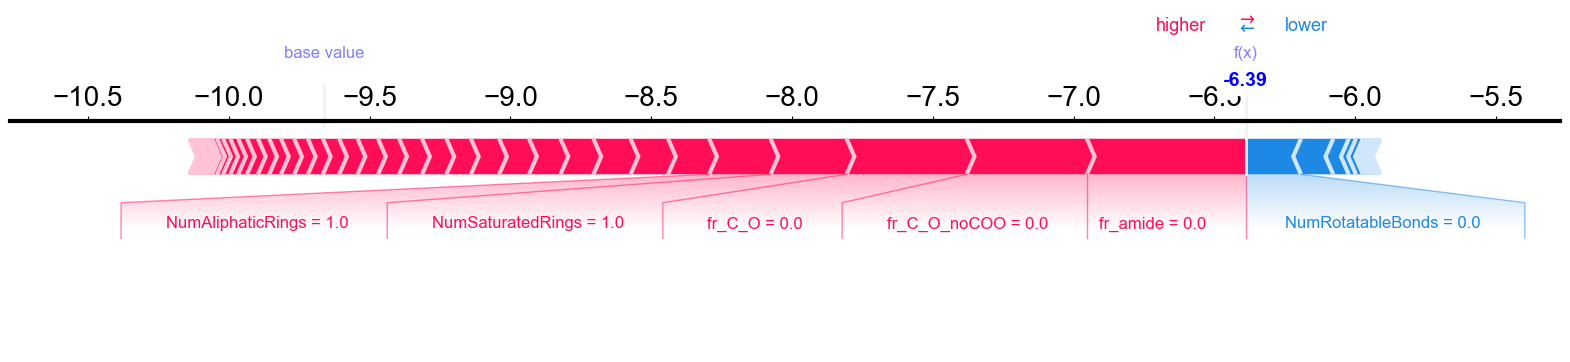

In [35]:
iloc = best_iloc
shap.initjs()
print(train_dataset[feature_column].iloc[iloc])
print(train_dataset['y'].iloc[iloc])
shap.force_plot(explainer.expected_value, shap_values[iloc], train_dataset[feature_column].iloc[iloc],matplotlib=True) 
shap.force_plot(explainer.expected_value, shap_values[iloc], train_dataset[feature_column].iloc[iloc]) 
